### 팀명 : Versatile
### 팀원 : 강지민, 박소연
### 주제명 : 투자, 건강한 문화가 되다
### 분류 목적 및 방식 : 빠르게 변화할 수 있는 개인의 투자성향을 반영하기 위해 매월말을 기준으로 데이터를 갱신하여 고객을 재분류

# 데이터 전처리

## 필요한 패키지 로드 및 데이터 로드

In [1]:
# 필요한 모듈 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 12 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (13.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [2]:
# 필요한 패키지 설치
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import rc
from yellowbrick.cluster import SilhouetteVisualizer
import math
import zipfile
import warnings
warnings.filterwarnings('ignore')
rc('font', family='NanumBarunGothic')

In [3]:
# 데이터 불러오기
!gdown --id 1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
zf = zipfile.ZipFile("경진대회 예선 데이터.zip")
zf.setpassword(b"nh1212!")
zf.extractall()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
To: /content/경진대회 예선 데이터.zip
100% 12.5M/12.5M [00:00<00:00, 175MB/s]


In [4]:
cus = pd.read_csv('./cus_ifo.csv')
kr = pd.read_csv('./kr_stk_orr.csv')
oss = pd.read_csv('./oss_stk_orr.csv')
cus_tot = pd.read_csv('./cus_tot_aet_ifo.csv')
cus_bnc = pd.read_csv('./cus_itg_sct_bnc.csv')

## 거래 주식에 따른 집단 분류
### 국내 주식만 투자 (only_ko) / 해외 주식만 투자 (only_oss) / 둘 다 투자 (both)

- 집단 분류

In [5]:
# 국내주식만 하는 집단
only_ko = cus[(cus['stk_pdt_hld_yn'] == 'Y') & (cus['ose_stk_pdt_hld_yn'] == 'N')]

# 해외주식만 하는 집단
only_oss = cus[(cus['stk_pdt_hld_yn'] == 'N') & (cus['ose_stk_pdt_hld_yn'] == 'Y')]

# 국내/해외주식 모두 하는 집단
both = cus[(cus['stk_pdt_hld_yn'] == 'Y') & (cus['ose_stk_pdt_hld_yn'] == 'Y')]

## 집단에 따른 월별 총 거래횟수 구하기

### 국내주식만 하는 경우 (only_ko)



In [6]:
# 국내주식만 하는 경우
only_ko_act = only_ko[['act_no', 'bse_ym']]

# 거래내역과 merge를 위한 거래내역 데이터 내 'bse_ym' 생성
kr['bse_ym'] = kr['orr_dt'].astype('string').str[:6]

only_ko_act['bse_ym'] = only_ko_act['bse_ym'].astype('string')
only_ko_kr = pd.merge(only_ko_act, kr, how = 'left',  on = ['act_no', 'bse_ym'])
only_ko_kr.fillna(0)

,act_no,bse_ym,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd
0,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202203,20220325.0,1.0,12.0,13.0,A005880,1.0,12.0,2750.0,3.0
1,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202202,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202205,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202201,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
452340,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202202,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452341,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202203,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452342,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202204,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452343,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202206,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


- 월별 거래횟수 총계 구하기

In [7]:
# 국내주식 only_ko 그룹 총 거래횟수 count
only_ko_orr_cnt = only_ko_kr.groupby(['act_no', 'bse_ym'])[['act_no']].count()
only_ko_orr_cnt = only_ko_orr_cnt.rename( columns = { 'act_no' : 'orr_tot_cnt'})
only_ko_orr_cnt.reset_index(inplace = True)
only_ko_orr_cnt

,act_no,bse_ym,orr_tot_cnt
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,1
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,1
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,1
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,1
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,1
...,...,...,...
46226,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202202,1
46227,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202203,1
46228,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202204,1
46229,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202205,1


- 월말기준 월별 보유종목 수 구하기

In [8]:
only_ko_tot_cnt = pd.merge( only_ko[['act_no', 'bse_ym']], cus_bnc, how = 'inner', on = ['act_no', 'bse_ym'])

# only_ko그룹 보유종목 개수
only_ko_tot_cnt_grouped1 = only_ko_tot_cnt.groupby(['act_no', 'bse_ym'])[['iem_cd']].count()
only_ko_tot_cnt_grouped1.reset_index( inplace = True )
only_ko_tot_cnt_grouped1 = only_ko_tot_cnt_grouped1.rename( columns = {'iem_cd' : 'iem_cnt'})
only_ko_tot_cnt_grouped1

,act_no,bse_ym,iem_cnt
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,4
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,5
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,4
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,4
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,4
...,...,...,...
46225,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202202,1
46226,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202203,1
46227,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202204,1
46228,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202205,1


- 데이터프레임 합치기

In [9]:
only_ko_orr_cnt['bse_ym'] = only_ko_orr_cnt['bse_ym'].astype('int')
only_ko_df = pd.merge(only_ko_orr_cnt, only_ko_tot_cnt_grouped1, how = 'inner', on = ['act_no', 'bse_ym'])
only_ko_df # only_ko 집단의 월별 거래횟수 총계와 보유 종목 수

,act_no,bse_ym,orr_tot_cnt,iem_cnt
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,1,4
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,1,5
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,1,4
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,1,4
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,1,4
...,...,...,...,...
46225,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202202,1,1
46226,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202203,1,1
46227,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202204,1,1
46228,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202205,1,1


In [10]:
# only_ko_df 에 대한 기술통계 확인
only_ko_df.describe()

,bse_ym,orr_tot_cnt,iem_cnt
count,46230.000000,46230.000000,46230.000000
mean,202203.538719,9.784642,6.055267
std,1.703155,65.849468,10.210264
min,202201.000000,1.000000,1.000000
25%,202202.000000,1.000000,2.000000
50%,202204.000000,1.000000,3.000000
75%,202205.000000,2.000000,7.000000
max,202206.000000,4058.000000,315.000000


### 해외주식만 하는 경우 (only_oss)

In [11]:
# merge를 위한 거래내역 데이터 내 'bse_ym' 생성
only_oss_act = only_oss[['act_no', 'bse_ym']]

oss['bse_ym'] = oss['orr_dt'].astype('string').str[:6]

only_oss_act['bse_ym'] = only_oss_act['bse_ym'].astype('string')
only_oss_orr = pd.merge(only_oss_act, oss, how = 'left',  on = ['act_no', 'bse_ym'])
only_ko_kr.fillna(0)

,act_no,bse_ym,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd
0,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202203,20220325.0,1.0,12.0,13.0,A005880,1.0,12.0,2750.0,3.0
1,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202202,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202205,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202201,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
452340,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202202,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452341,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202203,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452342,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202204,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
452343,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202206,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [12]:
# 해외주식 only_ko 그룹 총 거래횟수 count
only_oss_orr_cnt = only_oss_orr.groupby(['act_no', 'bse_ym'])[['act_no']].count()
only_oss_orr_cnt = only_oss_orr_cnt.rename( columns = { 'act_no' : 'orr_tot_cnt'})
only_oss_orr_cnt.reset_index(inplace = True)
only_oss_orr_cnt

,act_no,bse_ym,orr_tot_cnt
0,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202201,2
1,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202202,1
2,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202203,1
3,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202204,1
4,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202205,1
...,...,...,...
3418,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202202,1
3419,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202203,3
3420,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202204,1
3421,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202205,1


- 월말 기준 보유종목 수 구하기

In [13]:
only_oss_tot_cnt = pd.merge(  only_oss[['act_no', 'bse_ym']], cus_bnc, how = 'inner', on = ['act_no', 'bse_ym'])

# only_ko그룹 보유종목 개수
only_oss_tot_cnt_grouped1 = only_oss_tot_cnt.groupby(['act_no', 'bse_ym'])[['iem_cd']].count()
only_oss_tot_cnt_grouped1.reset_index( inplace = True )
only_oss_tot_cnt_grouped1 = only_oss_tot_cnt_grouped1.rename( columns = {'iem_cd' : 'iem_cnt'})
only_oss_tot_cnt_grouped1

,act_no,bse_ym,iem_cnt
0,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202201,1
1,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202202,1
2,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202203,1
3,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202204,1
4,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202205,1
...,...,...,...
3418,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202202,1
3419,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202203,2
3420,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202204,2
3421,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202205,2


- 데이터프레임 합치기

In [14]:
only_oss_orr_cnt['bse_ym'] = only_oss_orr_cnt['bse_ym'].astype('int')
only_oss_df = pd.merge(only_oss_orr_cnt, only_oss_tot_cnt_grouped1, how = 'inner', on = ['act_no', 'bse_ym'])
only_oss_df # only_oss 집단의 월별 거래횟수 총계와 보유 종목 수

,act_no,bse_ym,orr_tot_cnt,iem_cnt
0,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202201,2,1
1,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202202,1,1
2,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202203,1,1
3,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202204,1,1
4,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202205,1,1
...,...,...,...,...
3418,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202202,1,1
3419,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202203,3,2
3420,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202204,1,2
3421,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202205,1,2


### 국내/해외주식 모두하는 집단 (both) 의 경우

In [15]:
both_act = both[['act_no', 'bse_ym']]

In [16]:
# merge를 위한 거래내역 데이터 내 'bse_ym' 생성
kr['bse_ym'] = kr['orr_dt'].astype('string').str[:6]
oss['bse_ym'] = oss['orr_dt'].astype('string').str[:6]

both_act['bse_ym'] = both_act['bse_ym'].astype('string')
both_orr_kr = pd.merge(both_act, kr, how = 'left',  on = ['act_no', 'bse_ym'])
both_orr_kr.fillna(0)
both_orr_oss = pd.merge(both_act, oss, how = 'left',  on = ['act_no', 'bse_ym'])
both_orr_oss.fillna(0)

,act_no,bse_ym,orr_dt,orr_ord,orr_rtn_hur,lst_cns_hur,iem_cd,sby_dit_cd,cns_qty,orr_pr,orr_mdi_dit_cd,cur_cd,trd_cur_xcg_rt
0,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
1,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202203,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
2,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202205,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
3,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202206,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
4,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202201,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40632,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202201,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
40633,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202204,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
40634,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202202,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0
40635,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0


In [17]:
both_orr_kr1 = both_orr_kr[['act_no', 'bse_ym']]
both_orr_oss1 = both_orr_oss[['act_no', 'bse_ym']]
both_orr = pd.concat([both_orr_kr1, both_orr_oss1])
both_orr

,act_no,bse_ym
0,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202
1,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202203
2,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202205
3,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202206
4,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202201
...,...,...
40632,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202201
40633,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202204
40634,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202202
40635,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206


In [18]:
# both 그룹 총 거래횟수 count
both_orr_cnt = both_orr.groupby(['act_no', 'bse_ym'])[['act_no']].count()
both_orr_cnt = both_orr_cnt.rename( columns = { 'act_no' : 'orr_tot_cnt'})
both_orr_cnt.reset_index(inplace = True)
both_orr_cnt

,act_no,bse_ym,orr_tot_cnt
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,2
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,2
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,2
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,2
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,2
...,...,...,...
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,4
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,2
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,2
7149,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,2


- 월말기준 계좌당 월별 보유 종목 수 총계

In [19]:
both_tot_cnt = pd.merge( both[['act_no', 'bse_ym']], cus_bnc, how = 'inner', on = ['act_no', 'bse_ym'])

both_tot_cnt_grouped1 = both_tot_cnt.groupby(['act_no', 'bse_ym'])[['iem_cd']].count()
both_tot_cnt_grouped1.reset_index( inplace = True )
both_tot_cnt_grouped1 = both_tot_cnt_grouped1.rename( columns = {'iem_cd' : 'iem_cnt'})
both_tot_cnt_grouped1

,act_no,bse_ym,iem_cnt
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,45
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,45
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,45
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,46
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,46
...,...,...,...
7145,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,5
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,4
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,4
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,4


- 월말기준 계좌당 월별 국내/해외주식 투자비중 확인

In [20]:
both_merge = pd.merge( both, cus_bnc, on = ['act_no', 'bse_ym'], how = 'left')
both_merge

,cus_no,act_no,bse_ym,mts_mm_access_type,sex_dit_cd,cus_age_stn_cd,cus_aet_stn_cd,pft_amt_stn_cd,fst_act_opn_dt,stk_pdt_hld_yn,...,stl_bse_itg_bnc_qty,itg_byn_cns_qty,itg_sll_cns_qty,cns_bse_itg_bnc_qty,stl_bse_now_eal_amt,stl_bse_fc_now_eal_amt,cns_bse_now_eal_amt,cns_bse_fc_now_eal_amt,lon_amt,cur_cd
0,182671e1c1c704aa4435b776ab7815777a4d67694cbd0d...,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202,111101,2,8,2,1,20200622,Y,...,68.0,0.0,0.0,68.0,813746.0,676.60,813746.0,676.60,0.0,USD
1,182671e1c1c704aa4435b776ab7815777a4d67694cbd0d...,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202,111101,2,8,2,1,20200622,Y,...,30.0,0.0,0.0,30.0,633000.0,0.00,633000.0,0.00,0.0,KRW
2,182671e1c1c704aa4435b776ab7815777a4d67694cbd0d...,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202,111101,2,8,2,1,20200622,Y,...,3.0,0.0,0.0,3.0,481500.0,0.00,481500.0,0.00,0.0,KRW
3,182671e1c1c704aa4435b776ab7815777a4d67694cbd0d...,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202,111101,2,8,2,1,20200622,Y,...,5.0,0.0,0.0,5.0,1100000.0,0.00,1100000.0,0.00,0.0,KRW
4,182671e1c1c704aa4435b776ab7815777a4d67694cbd0d...,5fd6bda401bb8d978facb0427ac687823b5507335ba650...,202202,111101,2,8,2,1,20200622,Y,...,20.0,0.0,0.0,20.0,374000.0,0.00,374000.0,0.00,0.0,KRW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74346,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,111011,2,5,1,1,20210707,Y,...,1.0,0.0,0.0,1.0,41191.0,31.86,41191.0,31.86,0.0,USD
74347,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,111011,2,5,1,1,20210707,Y,...,4.0,0.0,0.0,4.0,155400.0,0.00,155400.0,0.00,0.0,KRW
74348,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202203,111011,2,5,1,1,20210707,Y,...,1.0,0.0,0.0,1.0,52064.0,43.00,52064.0,43.00,0.0,USD
74349,2be1d24c654b9730408b82716d21fb5ec27377dd3b5ca3...,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202203,111011,2,5,1,1,20210707,Y,...,1.0,0.0,1.0,0.0,21000.0,0.00,0.0,0.00,0.0,KRW


In [21]:
# 'iem_cd'가 국내인지 해외인지 판별 여부
both_merge['country_cd'] = both_merge['iem_cd'].str[0]

both_merge.loc[(both_merge['country_cd'] != 'A'), 'country_cd'] = '0' #해외는 0
both_merge.loc[(both_merge['country_cd'] == 'A'), 'country_cd'] = '1' #국내는 1

both_merge['country_cd'].value_counts() # 국가분류 확인

1    49846
0    24505
Name: country_cd, dtype: int64

In [22]:
# 월별 국내주식 총 투자금액 계산하기
both_merge_grouped = both_merge.groupby(['act_no', 'bse_ym', 'country_cd'])[['stl_bse_now_eal_amt']].sum()
both_merge_grouped.reset_index(inplace = True)
country_index = both_merge_grouped[both_merge_grouped['country_cd'] == '0'].index
both_merge_grouped.drop(country_index, inplace = True)
both_merge_grouped

,act_no,bse_ym,country_cd,stl_bse_now_eal_amt
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,1,38246070.0
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,1,39431230.0
5,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,1,39888280.0
7,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,1,38786020.0
9,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,1,38649210.0
...,...,...,...,...
14286,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,1,9261600.0
14288,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,1,8715100.0
14290,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,1,8267900.0
14292,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,1,8287400.0


In [23]:
# 월별 총 투자금액 계산하기
both_merge_sum = both_merge.groupby(['act_no', 'bse_ym'])[['stl_bse_now_eal_amt']].sum()
both_merge_sum = both_merge_sum.rename(columns = {'stl_bse_now_eal_amt' : 'sum'})
both_merge_sum.reset_index(inplace =True)
both_merge_sum

,act_no,bse_ym,sum
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,97221305.0
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,98926902.0
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,106077949.0
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,97304233.0
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,95933153.0
...,...,...,...
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,9271101.0
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,8728564.0
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,8277014.0
7149,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,8296357.0


In [24]:
both_merge2 = pd.merge(both_merge_grouped, both_merge_sum, how = 'inner', on = ['act_no', 'bse_ym'])

In [25]:
# 투자금액 기준 계좌별 국내/해외주식 투자 비율 확인
both_merge2['kr_ratio'] = round(both_merge2['stl_bse_now_eal_amt']/both_merge2['sum'] * 100)
both_merge2['oss_ratio'] = round(100- (both_merge2['stl_bse_now_eal_amt']/both_merge2['sum'] * 100))
both_merge2.reset_index(inplace = True)

# 필요한 칼럼만 추출
both_merge2 = both_merge2[['act_no', 'bse_ym', 'kr_ratio', 'oss_ratio', 'sum']]

both_merge2 # both그룹 내 금액 기준 투자비중 데이터

,act_no,bse_ym,kr_ratio,oss_ratio,sum
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,39.0,61.0,97221305.0
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,40.0,60.0,98926902.0
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,38.0,62.0,106077949.0
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,40.0,60.0,97304233.0
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,40.0,60.0,95933153.0
...,...,...,...,...,...
7145,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,100.0,0.0,9271101.0
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,100.0,0.0,8728564.0
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,100.0,0.0,8277014.0
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,100.0,0.0,8296357.0


- 데이터프레임 합치기

In [26]:
both_orr_cnt['bse_ym'] = both_orr_cnt['bse_ym'].astype('int')
both_df = pd.merge(both_orr_cnt, both_merge2, how = 'inner', on = ['act_no', 'bse_ym'])
both_df = pd.merge(both_df, both_tot_cnt_grouped1, how = 'inner', on = ['act_no', 'bse_ym'])
both_df # only_oss 집단의 월별 거래횟수 총계와 보유 종목 수

,act_no,bse_ym,orr_tot_cnt,kr_ratio,oss_ratio,sum,iem_cnt
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,2,39.0,61.0,97221305.0,45
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,2,40.0,60.0,98926902.0,45
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,2,38.0,62.0,106077949.0,45
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,2,40.0,60.0,97304233.0,46
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,2,40.0,60.0,95933153.0,46
...,...,...,...,...,...,...,...
7145,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,4,100.0,0.0,9271101.0,5
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,2,100.0,0.0,8728564.0,4
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,2,100.0,0.0,8277014.0,4
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,2,100.0,0.0,8296357.0,4


- 세 집단 데이터를 하나로 병합

In [27]:
df_list =[only_ko_df, only_oss_df, both_df]
df_final = pd.concat(df_list, ignore_index = True)
df_final

,act_no,bse_ym,orr_tot_cnt,iem_cnt,kr_ratio,oss_ratio,sum
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,1,4,NaN,NaN,NaN
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,1,5,NaN,NaN,NaN
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,1,4,NaN,NaN,NaN
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,1,4,NaN,NaN,NaN
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,1,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
56798,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,4,5,100.0,0.0,9271101.0
56799,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,2,4,100.0,0.0,8728564.0
56800,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,2,4,100.0,0.0,8277014.0
56801,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,2,4,100.0,0.0,8296357.0


## 집중/분산투자 성향을 나타나는 분산투자 지수 (dist_index) 구하기
- **dist_index : dist에 대한 std (표준편차) 값**
- dist (개별 종목에 대한 투자 비율) = (개별 종목 투자 금액) / (보유 종목들에 대한 총 투자 금액)
- 월말 잔고 기준으로 계좌당 보유 종목에 대한 투입 비율 확인
- 이는 투입 비중들에 대한 분산을 반영하여, 분산투자 비중의 분산 정도를 나타낼 수 있음

[ dist_index 공식을 도출한 과정 ] 

월말 기준 한 계좌에 대한 분산투자 지수를 구하기 위해, 
1. 한 계좌에 대하여 보유한 종목의 금액 비중에 대한 백분율을 구한다.
2. 각 종목의 백분율의 분산을 구하여, 분산이 높을수록 몇몇 특정 종목에 대한 집중 투자를 하고 있다고 판단하고, 분산이 낮을수록 분산투자를 하고 있다고 판단한다.
- 월말 기준 보유종목의 개수가 1개일 경우, 완전히 집중 투자를 하고 있는것으로 판단할 수 있다. 
- 하지만 분산을 구할 경우, 0이 나오므로 해당 경우 1로 대체한다.

In [28]:
# 월말 잔고 정보 불러오기
cus_bnc

,act_no,bse_ym,iem_cd,fc_sec_trd_nat_cd,itg_pdt_tp_cd,stl_bse_itg_bnc_qty,itg_byn_cns_qty,itg_sll_cns_qty,cns_bse_itg_bnc_qty,stl_bse_now_eal_amt,stl_bse_fc_now_eal_amt,cns_bse_now_eal_amt,cns_bse_fc_now_eal_amt,lon_amt,cur_cd
0,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202205,A101240,0,10,14.0,0.0,0.0,14.0,101640.0,0.0,101640.0,0.0,0.0,KRW
1,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202205,A900120,0,10,341.0,0.0,341.0,0.0,87978.0,0.0,0.0,0.0,0.0,KRW
2,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202205,A024910,0,10,32.0,0.0,32.0,0.0,77280.0,0.0,0.0,0.0,0.0,KRW
3,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202204,A263020,0,10,52.0,0.0,0.0,52.0,184600.0,0.0,184600.0,0.0,0.0,KRW
4,e97920ce7d2205d876398178d56a854ebe6aa84f46a9ff...,202204,A037030,0,10,18.0,0.0,0.0,18.0,89010.0,0.0,89010.0,0.0,0.0,KRW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366792,8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...,202203,A005930,0,10,2.0,0.0,0.0,2.0,139200.0,0.0,139200.0,0.0,0.0,KRW
366793,8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...,202205,A353590,0,10,2.0,0.0,0.0,2.0,29400.0,0.0,29400.0,0.0,0.0,KRW
366794,8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...,202204,A353590,0,10,2.0,0.0,0.0,2.0,30200.0,0.0,30200.0,0.0,0.0,KRW
366795,8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...,202203,A353590,0,10,0.0,2.0,0.0,2.0,0.0,0.0,48100.0,0.0,0.0,KRW


In [29]:
# 계좌/고객정보년월/종목코드에 따라 결제기준 현재평가 금액 합계 계산 

## 종목당 투자금액 확인
cus_bnc_grouped = cus_bnc.groupby(['act_no', 'bse_ym', 'iem_cd'])[['stl_bse_now_eal_amt']].sum()
cus_bnc_grouped

stl_bse_now_eal_amt
act_no                                             bse_ym iem_cd                           
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060                   58100.0
                                                          A391710                   39185.0
                                                          A396770                   63300.0
                                                          A400760                   55660.0
                                                   202202 A377330                   25000.0
...                                                                                     ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K                       0.0
                                                   202204 A27957K                       0.0
                                                   202205 A27957K                       0.0
                                                   202206 A279570                       0.0
                                                          A27957K                       0.0

[366797 rows x 1 columns]

In [30]:
# 고객정보년월당 투자금액 확인 (계좌 하나당 월별 주식 잔고 합계 확인)
cus_bnc_grouped.sum(axis =0, level= [0,1])

stl_bse_now_eal_amt
act_no                                             bse_ym                     
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201             216245.0
                                                   202202             242995.0
                                                   202203             220075.0
                                                   202204             233820.0
                                                   202205             235035.0
...                                                                        ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202202                  0.0
                                                   202203                  0.0
                                                   202204                  0.0
                                                   202205                  0.0
                                                   202206                  0.0

[57531 rows x 1 columns]

In [31]:
# dist (개별 종목에 대한 투자 비율) = (개별 종목 투자 금액) / (보유 종목들에 대한 총 투자 금액)
cus_bnc_grouped['dist'] = cus_bnc_grouped.sum(axis=0, level=[0,1,2])/cus_bnc_grouped.sum(axis =0, level= [0,1] )
cus_bnc_grouped = cus_bnc_grouped.fillna(0)

In [32]:
cus_bnc_grouped

stl_bse_now_eal_amt  \
act_no                                             bse_ym iem_cd                              
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060                   58100.0   
                                                          A391710                   39185.0   
                                                          A396770                   63300.0   
                                                          A400760                   55660.0   
                                                   202202 A377330                   25000.0   
...                                                                                     ...   
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K                       0.0   
                                                   202204 A27957K                       0.0   
                                                   202205 A27957K                       0.0   
                                                   202206 A279570                       0.0   
                                                          A27957K                       0.0   

                                                                            dist  
act_no                                             bse_ym iem_cd                  
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060       0.268677  
                                                          A391710       0.181207  
                                                          A396770       0.292724  
                                                          A400760       0.257393  
                                                   202202 A377330       0.102883  
...                                                                          ...  
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K       0.000000  
                                                   202204 A27957K       0.000000  
                                                   202205 A27957K       0.000000  
                                                   202206 A279570       0.000000  
                                                          A27957K       0.000000  

[366797 rows x 2 columns]

In [33]:
# 결측치 확인
cus_bnc_grouped['dist'].isna().sum()

0

In [34]:
# dist 칼럼에 대한 value_counts
cus_bnc_grouped['dist'].value_counts()

0.000000    34342
1.000000    12747
0.893075        9
0.454545        9
0.106925        9
            ...  
0.096112        1
0.146792        1
0.129305        1
0.254936        1
0.617818        1
Name: dist, Length: 318147, dtype: int64

In [35]:
# dist 칼럼에 대한 표준편차 std 값을 계산 -> dist_index
cus_std = cus_bnc_grouped.groupby(['act_no', 'bse_ym'])[['dist']].std()
cus_std

dist
act_no                                             bse_ym          
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201  0.048171
                                                   202202  0.065974
                                                   202203  0.049125
                                                   202204  0.039952
                                                   202205  0.030148
...                                                             ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202202       NaN
                                                   202203       NaN
                                                   202204       NaN
                                                   202205       NaN
                                                   202206  0.000000

[57531 rows x 1 columns]

In [36]:
cus_std.reset_index(inplace = True)
cus_std = cus_std.rename( columns = { 'dist' : 'dist_index'})
cus_std = cus_std.fillna(1) # 월별 보유 종목이 1개인 경우(완전 집중투자) -> null 값처리 -> null값을 1로 대체
cus_std

,act_no,bse_ym,dist_index
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,0.048171
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,0.065974
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,0.049125
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,0.039952
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,0.030148
...,...,...,...
57526,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202202,1.000000
57527,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202203,1.000000
57528,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202204,1.000000
57529,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202205,1.000000


In [37]:
# dist_index(분산투자 지수) 에 대한 기술통계 확인
cus_std['dist_index'].describe()

count    57531.000000
mean         0.402812
std          0.360450
min          0.000000
25%          0.112627
50%          0.241552
75%          0.697578
max          1.000000
Name: dist_index, dtype: float64

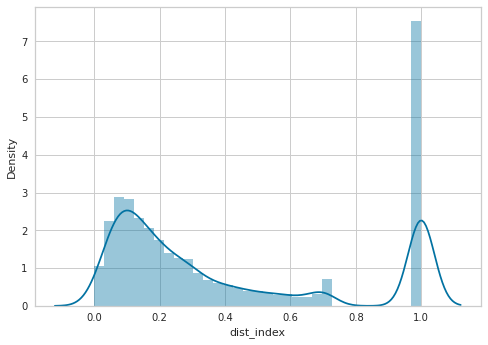

In [38]:
# dist_index의 분포 확인
sns.distplot(cus_std['dist_index'])

[ 계좌당 보유 종목의 개수가 1인 경우, 발생하는 문제 해결 ] 
- 계좌당 보유 종목의 개수가 1인 경우 => dist_index 계산 결과, 값이 1개이기 때문에 결측치 NaN으로 처리됨
- 하나의 계좌에서 종목을 1개만 보유한다는 것은 하나의 종목에만 '집중'투자를 한다는 것을 의미 

- 그렇기 때문에, **해당 NaN들에 dist_index의 최대값 1로 대체**

In [39]:
df_final

,act_no,bse_ym,orr_tot_cnt,iem_cnt,kr_ratio,oss_ratio,sum
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,1,4,NaN,NaN,NaN
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,1,5,NaN,NaN,NaN
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,1,4,NaN,NaN,NaN
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,1,4,NaN,NaN,NaN
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,1,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...
56798,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,4,5,100.0,0.0,9271101.0
56799,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,2,4,100.0,0.0,8728564.0
56800,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,2,4,100.0,0.0,8277014.0
56801,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,2,4,100.0,0.0,8296357.0


In [40]:
df_final[df_final['iem_cnt'] == 1]

,act_no,bse_ym,orr_tot_cnt,iem_cnt,kr_ratio,oss_ratio,sum
12,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,202203,1,1,NaN,NaN,NaN
13,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,202204,1,1,NaN,NaN,NaN
14,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,202205,1,1,NaN,NaN,NaN
15,0013250ee6bc012ce49a9eae6929a65cf50a1844c564de...,202206,1,1,NaN,NaN,NaN
16,002f84a03e2b6300db16322799882cc6b7201022b62fc9...,202203,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...
49636,fd998f5923833cc512c1b8e6bf767863a30114e32f2b0f...,202204,1,1,NaN,NaN,NaN
49637,fd998f5923833cc512c1b8e6bf767863a30114e32f2b0f...,202205,1,1,NaN,NaN,NaN
49638,fd998f5923833cc512c1b8e6bf767863a30114e32f2b0f...,202206,3,1,NaN,NaN,NaN
49647,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202201,1,1,NaN,NaN,NaN


(-1.0, 50.0)

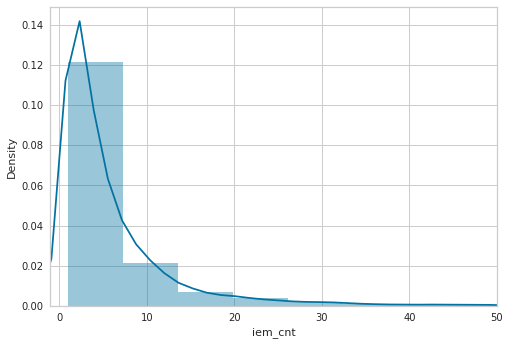

In [41]:
sns.distplot(df_final['iem_cnt'])
plt.xlim(-1, 50)

## 종목별 가격변동성 지수 (total_var_index) 계산
- 데이터 수집 한계로, 국내 주식에 투자한 집단 only_ko 에만 종목변 변동성 지수 적용 가능
- 해당 지수를 통해 하나의 계좌의 변동성을 고려한 투자 성향을 파악 가능

- **total_var_index (월 가격변동성) = np.std(등락률 컬럼)*np.sqrt(한 달 날짜 수)**
  - : (한달 동안의 일별 주가 변동성(=등락률)의 표준편차) * (한달 간 거래일수의 제곱근)


- **역사적 변동성 공식**을 이용
- 역사적 변동성
: 역사적 변동성은 주로 20~30일 정도의 기초자산(KOSPI200)의 표준편차를 이용하여 구하게 되는데 만약 그 기간 중 시장의 충격, 특이한 수급요건 등으로 역사적 변동성 자체가 과대평가 혹은 과소평가되어 있다면 이를 기준으로 한 변동성매매 포지션은 오류를 가질 수 있게 된다.
[ 출처 : 네이버 지식백과/매일경제 ]

### - 국내 주식 시세 데이터를 통한 일별 개별종목에 대한 변동성 계산

### 국내주식시세 외부 데이터 가져오기 (from 공공데이터포털, 금융위원회 api)

In [42]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [43]:
import requests
from urllib.request import Request, urlopen
from urllib.parse import urlencode, quote_plus

url = 'https://apis.data.go.kr/1160100/service/GetStockSecuritiesInfoService/getStockPriceInfo'
key = '+7YcEiUcE/0x81fraVQ3Z/IWu/PJfJ9byUoD+tgu6/MwGVpvmL4ZoUF+quybPoyZSNkylXOezkFcI+gVJjpzKA=='

queryParams = '?' + urlencode({quote_plus('serviceKey') : key,
                               quote_plus('numOfRows') : '1000',
                               quote_plus('resultType') : 'json',
                               quote_plus('beginBasDt') : '20220101', 
                               quote_plus('endBasDt') : '20220701' })

response = urlopen(url + queryParams)
json_api = response.read().decode("utf-8")

In [44]:
print(response)

In [45]:
json_api

'{"response":{"header":{"resultCode":"00","resultMsg":"NORMAL SERVICE."},"body":{"numOfRows":1000,"pageNo":1,"totalCount":316966,"items":{"item":[{"basDt":"20220630","srtnCd":"900110","isinCd":"HK0000057197","itmsNm":"이스트아시아홀딩스","mrktCtg":"KOSDAQ","clpr":"229","vs":"-10","fltRt":"-4.18","mkp":"245","hipr":"245","lopr":"226","trqu":"2653240","trPrc":"625268898","lstgStCnt":"201982155","mrktTotAmt":"46253913495"},{"basDt":"20220630","srtnCd":"900270","isinCd":"HK0000214814","itmsNm":"헝셩그룹","mrktCtg":"KOSDAQ","clpr":"364","vs":"-15","fltRt":"-3.96","mkp":"377","hipr":"377","lopr":"362","trqu":"1267972","trPrc":"464701824","lstgStCnt":"82824858","mrktTotAmt":"30148248312"},{"basDt":"20220630","srtnCd":"900260","isinCd":"HK0000295359","itmsNm":"로스웰","mrktCtg":"KOSDAQ","clpr":"309","vs":"-18","fltRt":"-5.5","mkp":"334","hipr":"334","lopr":"309","trqu":"2006526","trPrc":"632929792","lstgStCnt":"180156443","mrktTotAmt":"55668340887"},{"basDt":"20220630","srtnCd":"900290","isinCd":"HK0000307485

In [46]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json


r_dict = json.loads(json_api)

numOfRows = r_dict['response']['body']['numOfRows']
totCnt = r_dict['response']['body']['totalCount']

print('numOfRows : ' + str(numOfRows))
print('-----------------------')
print('totCnt : ' +  str(totCnt))

numOfRows : 1000
-----------------------
totCnt : 316966


In [47]:
import math
loopCount = math.ceil(totCnt/numOfRows)

In [48]:
finalTotalData = pd.DataFrame()

- 아래 for문에 대한 예상 수행시간 : 약 20분

In [49]:
'''

for i in np.arange(loopCount):

  # queryparams
  key = '+7YcEiUcE/0x81fraVQ3Z/IWu/PJfJ9byUoD+tgu6/MwGVpvmL4ZoUF+quybPoyZSNkylXOezkFcI+gVJjpzKA=='

  queryParams = '?' + urlencode({quote_plus('serviceKey') : key,
                               quote_plus('numOfRows') : '1000',
                               quote_plus('resultType') : 'json',
                               quote_plus('beginBasDt') : '20220101', 
                               quote_plus('endBasDt') : '20220701' })

  # 최종 URL 생성
  queryURL = url + queryParams

  # API 호출
  response = urlopen(url + queryParams)
  json_api = response.read().decode("utf-8")

  # 딕셔너리 형태로 변환
  r_dict = json.loads(json_api)

  # 데이터프레임만 선택하여 doc 객체에 저장
  doc = r_dict['response']['body']['items']['item']

  # 추출한 데이터를 저장할 변수에 누적 저장
  finalTotalData = pd.concat([finalTotalData, pd.DataFrame(doc)], axis = 0, ignore_index = True)

# csv 파일로 저장
finalTotalData.to_csv('stk_data.csv', index = False, encoding = 'utf-8-sig')

'''

'\n\nfor i in np.arange(loopCount):\n\n  # queryparams\n  key = \'+7YcEiUcE/0x81fraVQ3Z/IWu/PJfJ9byUoD+tgu6/MwGVpvmL4ZoUF+quybPoyZSNkylXOezkFcI+gVJjpzKA==\'\n\n  queryParams = \'?\' + urlencode({quote_plus(\'serviceKey\') : key,\n                               quote_plus(\'numOfRows\') : \'1000\',\n                               quote_plus(\'resultType\') : \'json\',\n                               quote_plus(\'beginBasDt\') : \'20220101\', \n                               quote_plus(\'endBasDt\') : \'20220701\' })\n\n  # 최종 URL 생성\n  queryURL = url + queryParams\n\n  # API 호출\n  response = urlopen(url + queryParams)\n  json_api = response.read().decode("utf-8")\n\n  # 딕셔너리 형태로 변환\n  r_dict = json.loads(json_api)\n\n  # 데이터프레임만 선택하여 doc 객체에 저장\n  doc = r_dict[\'response\'][\'body\'][\'items\'][\'item\']\n\n  # 추출한 데이터를 저장할 변수에 누적 저장\n  finalTotalData = pd.concat([finalTotalData, pd.DataFrame(doc)], axis = 0, ignore_index = True)\n\n# csv 파일로 저장\nfinalTotalData.to_csv(\'stk_data.csv\', 

In [50]:
# 칼럼명 한글로 변경
finalTotalData = finalTotalData.rename(columns = {
                      'basDt' : '기준일자', 
                      'srtnCd' : '단축코드', 
                      'isinCd' : 'ISIN코드',
                      'itmsNm' : '종목명',
                      'mrktCtg' : '시장구분',
                      'mkp' : '시가',
                      'clpr' : '종가',
                      'vs' : '대비',
                      'fltRt' : '등락률',
                      'hipr' : '고가',
                      'lopr' : '저가',
                      'trqu' : '거래량',
                      'trPrc' : '거래대금',
                      'lstgStCnt' : '상장주식수',
                      'mrktTotAmt' : '시가총액'})

### 개별 종목에 대한 변동률 구하기

In [51]:
# 데이터 불러오기
!gdown --id 1mqCmr-DUDVWoEDMCmi4cZM7BGrZ1r6QV
a = zipfile.ZipFile("stk_df.zip")
a.extractall()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1mqCmr-DUDVWoEDMCmi4cZM7BGrZ1r6QV
To: /content/stk_df.zip
100% 15.3M/15.3M [00:00<00:00, 123MB/s] 


In [52]:
marketprice = pd.read_csv('./stk_df.csv')

In [53]:
marketprice.info() # 기본정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316966 entries, 0 to 316965
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   기준일자    316966 non-null  int64  
 1   단축코드    316966 non-null  object 
 2   ISIN코드  316966 non-null  object 
 3   종목명     316966 non-null  object 
 4   시장구분    316966 non-null  object 
 5   종가      316966 non-null  int64  
 6   대비      316966 non-null  int64  
 7   등락률     316966 non-null  float64
 8   시가      316966 non-null  int64  
 9   고가      316966 non-null  int64  
 10  저가      316966 non-null  int64  
 11  거래량     316966 non-null  int64  
 12  거래대금    316966 non-null  int64  
 13  상장주식수   316966 non-null  int64  
 14  시가총액    316966 non-null  int64  
dtypes: float64(1), int64(10), object(4)
memory usage: 36.3+ MB


In [54]:
marketprice

,기준일자,단축코드,ISIN코드,종목명,시장구분,종가,대비,등락률,시가,고가,저가,거래량,거래대금,상장주식수,시가총액
0,20220630,900110,HK0000057197,이스트아시아홀딩스,KOSDAQ,229,-10,-4.18,245,245,226,2653240,625268898,201982155,46253913495
1,20220630,900270,HK0000214814,헝셩그룹,KOSDAQ,364,-15,-3.96,377,377,362,1267972,464701824,82824858,30148248312
2,20220630,900260,HK0000295359,로스웰,KOSDAQ,309,-18,-5.50,334,334,309,2006526,632929792,180156443,55668340887
3,20220630,900290,HK0000307485,GRT,KOSDAQ,1245,10,0.81,1245,1250,1235,225965,280570320,67375000,83881875000
4,20220630,900300,HK0000312568,오가닉티코스메틱,KOSDAQ,370,-20,-5.13,388,398,367,3363845,1280493196,126552480,46824417600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316961,20220103,900120,KYG2114A1094,씨케이에이치,KOSDAQ,300,48,19.05,258,327,258,37708444,11856573341,120449666,36134899800
316962,20220103,900250,KYG2115T1076,크리스탈신소재,KOSDAQ,1390,50,3.73,1350,1415,1315,3725081,5122470575,67783852,94219554280
316963,20220103,900070,KYG3931T1076,글로벌에스엠,KOSDAQ,1040,40,4.00,1010,1110,999,2135296,2262664487,53743968,55893726720
316964,20220103,900140,KYG5307W1015,엘브이엠씨홀딩스,KOSPI,3685,45,1.24,3740,3740,3640,469504,1732369490,99455297,366492769445


In [55]:
marketprice['단축코드']='A'+marketprice['단축코드']

In [56]:
# 기준일자 Datetime 형으로 변환
marketprice['기준일자'] = pd.to_datetime(marketprice['기준일자'],format='%Y%m%d')

In [57]:
marketprice['기준일자']

0        2022-06-30
1        2022-06-30
2        2022-06-30
3        2022-06-30
4        2022-06-30
            ...    
316961   2022-01-03
316962   2022-01-03
316963   2022-01-03
316964   2022-01-03
316965   2022-01-03
Name: 기준일자, Length: 316966, dtype: datetime64[ns]

In [58]:
marketprice.set_index(keys ='기준일자',inplace=True)

In [59]:
marketprice['Month'] = marketprice.index.month

In [60]:
grouped = marketprice.groupby(['Month','종목명','단축코드'])

In [61]:
## 변동성 식 : np.std(등락률 컬럼)*np.sqrt(한 달 날짜 수)

var_index = grouped.agg({'등락률':lambda x : np.std(x)*np.sqrt(x.count())})

In [62]:
var_index = var_index.rename(columns={'등락률':'변동성'})
var_index

변동성
Month 종목명     단축코드              
1     3S      A060310  17.317245
      AJ네트웍스  A095570   7.103533
      AK홀딩스   A006840  13.852999
      APS홀딩스  A054620  15.306381
      AP시스템   A265520  10.236747
...                          ...
6     흥국화재2우B A000547  13.021017
      흥국화재우   A000545  14.443997
      흥아해운    A003280  14.542145
      희림      A037440  40.718067
      힘스      A238490  10.892719

[15837 rows x 1 columns]

In [63]:
var_index.to_csv('var_index.csv')

### 월말기준 월별 보유종목과 종목 당 투자금액 비율 확인

In [64]:
only_ko_iem = pd.merge( only_ko[['act_no', 'bse_ym']], cus_bnc, how = 'inner', on = ['act_no', 'bse_ym'])
only_ko_iem_grouped = only_ko_iem.groupby(['act_no', 'bse_ym', 'iem_cd'])[['stl_bse_now_eal_amt']].sum()
only_ko_iem_grouped = only_ko_iem_grouped.rename(columns = {'stl_bse_now_eal_amt' : 'iem_amt'})
only_ko_iem_grouped

iem_amt
act_no                                             bse_ym iem_cd               
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060       58100.0
                                                          A391710       39185.0
                                                          A396770       63300.0
                                                          A400760       55660.0
                                                   202202 A377330       25000.0
...                                                                         ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K           0.0
                                                   202204 A27957K           0.0
                                                   202205 A27957K           0.0
                                                   202206 A279570           0.0
                                                          A27957K           0.0

[279935 rows x 1 columns]

In [65]:
only_ko_iem_grouped['ratio'] = only_ko_iem_grouped.sum(axis=0, level=[0,1,2])/only_ko_iem_grouped.sum(axis =0, level= [0,1] )
only_ko_iem_grouped['ratio'] = only_ko_iem_grouped['ratio']
only_ko_iem_ratio = only_ko_iem_grouped
only_ko_iem_ratio

iem_amt  \
act_no                                             bse_ym iem_cd                  
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060       58100.0   
                                                          A391710       39185.0   
                                                          A396770       63300.0   
                                                          A400760       55660.0   
                                                   202202 A377330       25000.0   
...                                                                         ...   
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K           0.0   
                                                   202204 A27957K           0.0   
                                                   202205 A27957K           0.0   
                                                   202206 A279570           0.0   
                                                          A27957K           0.0   

                                                                           ratio  
act_no                                             bse_ym iem_cd                  
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060       0.268677  
                                                          A391710       0.181207  
                                                          A396770       0.292724  
                                                          A400760       0.257393  
                                                   202202 A377330       0.102883  
...                                                                          ...  
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K            NaN  
                                                   202204 A27957K            NaN  
                                                   202205 A27957K            NaN  
                                                   202206 A279570            NaN  
                                                          A27957K            NaN  

[279935 rows x 2 columns]

In [66]:
# 종목 당 투자금액 ratio 기술통계 확인
only_ko_iem_ratio.describe()

,iem_amt,ratio
count,2.799350e+05,277943.000000
mean,3.501888e+06,0.160447
std,1.697195e+07,0.251804
min,0.000000e+00,0.000000
25%,9.810000e+04,0.010763
50%,5.738000e+05,0.049977
75%,2.205000e+06,0.179562
max,1.628060e+09,1.000000


In [67]:
only_ko_iem_ratio # 국내주식투자집단 (only_ko)의 계좌당 종목 보유 비중 정보

iem_amt  \
act_no                                             bse_ym iem_cd                  
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060       58100.0   
                                                          A391710       39185.0   
                                                          A396770       63300.0   
                                                          A400760       55660.0   
                                                   202202 A377330       25000.0   
...                                                                         ...   
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K           0.0   
                                                   202204 A27957K           0.0   
                                                   202205 A27957K           0.0   
                                                   202206 A279570           0.0   
                                                          A27957K           0.0   

                                                                           ratio  
act_no                                             bse_ym iem_cd                  
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201 A391060       0.268677  
                                                          A391710       0.181207  
                                                          A396770       0.292724  
                                                          A400760       0.257393  
                                                   202202 A377330       0.102883  
...                                                                          ...  
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202203 A27957K            NaN  
                                                   202204 A27957K            NaN  
                                                   202205 A27957K            NaN  
                                                   202206 A279570            NaN  
                                                          A27957K            NaN  

[279935 rows x 2 columns]

### 하나의 계좌에 대한 변동성 지수 나타내기

In [68]:
# 데이터 불러오기
!gdown --id 18dcPOJjaP-CGFN9w2G0KqNJkoV94G8ss
zf = zipfile.ZipFile("var_index.csv.zip")
zf.extractall()

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18dcPOJjaP-CGFN9w2G0KqNJkoV94G8ss
To: /content/var_index.csv.zip
100% 296k/296k [00:00<00:00, 84.1MB/s]


In [69]:
# 데이터 로드
var_index = pd.read_csv('./var_index.csv') # 개별 종목들에 대한 변동성 인덱스 정보
ratio = only_ko_iem_ratio

In [70]:
var_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15837 entries, 0 to 15836
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   15837 non-null  int64  
 1   종목명     15837 non-null  object 
 2   단축코드    15837 non-null  object 
 3   변동성     15837 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 495.0+ KB


In [71]:
# merge를 위한 데이터 전처리
var_index['Month'] = var_index['Month'].astype('string')
var_index['bse_ym'] = '2022' + '0' + var_index['Month']
var_index

,Month,종목명,단축코드,변동성,bse_ym
0,1,3S,A060310,17.317245,202201
1,1,AJ네트웍스,A095570,7.103533,202201
2,1,AK홀딩스,A006840,13.852999,202201
3,1,APS홀딩스,A054620,15.306381,202201
4,1,AP시스템,A265520,10.236747,202201
...,...,...,...,...,...
15832,6,흥국화재2우B,A000547,13.021017,202206
15833,6,흥국화재우,A000545,14.443997,202206
15834,6,흥아해운,A003280,14.542145,202206
15835,6,희림,A037440,40.718067,202206


In [72]:
var_index['iem_cd'] = var_index['단축코드']
var_index['variability'] = var_index['변동성']
var_index = var_index[['bse_ym', 'iem_cd', 'variability']] #필요한 칼럼만 추출
var_index

,bse_ym,iem_cd,variability
0,202201,A060310,17.317245
1,202201,A095570,7.103533
2,202201,A006840,13.852999
3,202201,A054620,15.306381
4,202201,A265520,10.236747
...,...,...,...
15832,202206,A000547,13.021017
15833,202206,A000545,14.443997
15834,202206,A003280,14.542145
15835,202206,A037440,40.718067


In [73]:
ratio.reset_index(inplace = True)
ratio.head() # merge할 데이터 확인

,act_no,bse_ym,iem_cd,iem_amt,ratio
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A391060,58100.0,0.268677
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A391710,39185.0,0.181207
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A396770,63300.0,0.292724
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A400760,55660.0,0.257393
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,A377330,25000.0,0.102883


In [74]:
# merge를 위한 텍스트 데이터 전처리 : 불필요한 공백 제거
ratio['iem_cd'] = ratio['iem_cd'].str.rstrip()
ratio['bse_ym'] = ratio['bse_ym'].astype('string')
df = pd.merge(ratio, var_index, how = 'left', on = ['iem_cd', 'bse_ym'])
df

,act_no,bse_ym,iem_cd,iem_amt,ratio,variability
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A391060,58100.0,0.268677,1.149748
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A391710,39185.0,0.181207,0.000000
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A396770,63300.0,0.292724,3.211662
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,A400760,55660.0,0.257393,2.284840
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,A377330,25000.0,0.102883,24.224224
...,...,...,...,...,...,...
281472,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202203,A27957K,0.0,NaN,NaN
281473,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202204,A27957K,0.0,NaN,NaN
281474,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202205,A27957K,0.0,NaN,NaN
281475,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202206,A279570,0.0,NaN,NaN


[ 종목명은 존재하지만 잔고 수량이 없는 경우, 발생하는 문제 해결 ] 
- 종목명은 존재하지만 잔고 수량이 없는 경우 => ratio, variability 칼럼에 대한 value 값이 모두 결측치 NaN 처리
- 잔고 수량이 없기 때문에 **ratio, variability 값은 0으로 대체**

In [75]:
# 결측치 처리
df = df.fillna(0)

- 계좌당 변동성 지수 : 'ratio'와 'variability' 내적하여 값 도출
- 각 종목에 대한 variability에 투입 비중인 ratio 를 가중치로 설정하여 계좌당 total 변동성 지수를 산출

In [76]:
df['total'] = df['ratio'] * df['variability']
df_grouped = df.groupby(['act_no', 'bse_ym'])[['total']].sum()
df_grouped

total
act_no                                             bse_ym          
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201  1.837142
                                                   202202  3.477071
                                                   202203  0.940831
                                                   202204  4.431948
                                                   202205  5.685369
...                                                             ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202202  0.000000
                                                   202203  0.000000
                                                   202204  0.000000
                                                   202205  0.000000
                                                   202206  0.000000

[46230 rows x 1 columns]

Text(0.5, 1.0, 'total_var_index 분포 확인')

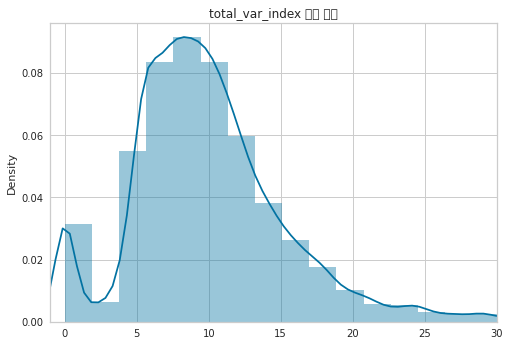

In [77]:
sns.distplot(df_grouped)
plt.xlim(-1, 30)
plt.title('total_var_index 분포 확인')

In [78]:
df_grouped.reset_index(inplace = True)
tot_var_index = df_grouped # tot_var_index 데이터프레임으로 저장

### 월말 잔고 전체 투자금액 대비 대출금액 계산 -> 무의미한 변수로 판단

In [79]:
# 고객정보년월당 투자금액 확인 (계좌 하나당 월별 주식 잔고 합계 확인)
cus_bnc_tot = cus_bnc_grouped.sum(axis =0, level= [0,1])
cus_bnc_tot = cus_bnc_tot[['stl_bse_now_eal_amt']]
cus_bnc_tot

stl_bse_now_eal_amt
act_no                                             bse_ym                     
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201             216245.0
                                                   202202             242995.0
                                                   202203             220075.0
                                                   202204             233820.0
                                                   202205             235035.0
...                                                                        ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202202                  0.0
                                                   202203                  0.0
                                                   202204                  0.0
                                                   202205                  0.0
                                                   202206                  0.0

[57531 rows x 1 columns]

In [80]:
cus_bnc_loan = cus_bnc.groupby(['act_no', 'bse_ym'])[['lon_amt']].sum()
cus_bnc_loan

lon_amt
act_no                                             bse_ym         
0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddcb... 202201      0.0
                                                   202202      0.0
                                                   202203      0.0
                                                   202204      0.0
                                                   202205      0.0
...                                                            ...
ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790a... 202202      0.0
                                                   202203      0.0
                                                   202204      0.0
                                                   202205      0.0
                                                   202206      0.0

[57531 rows x 1 columns]

In [81]:
cus_bnc_loan['lon_amt'].value_counts()

0.0           56764
5000000.0        11
20020000.0        7
5064000.0         5
20723000.0        5
              ...  
11750000.0        1
9070000.0         1
12703500.0        1
9306000.0         1
15850000.0        1
Name: lon_amt, Length: 649, dtype: int64

Text(0.5, 1.0, '대출금액 분포')

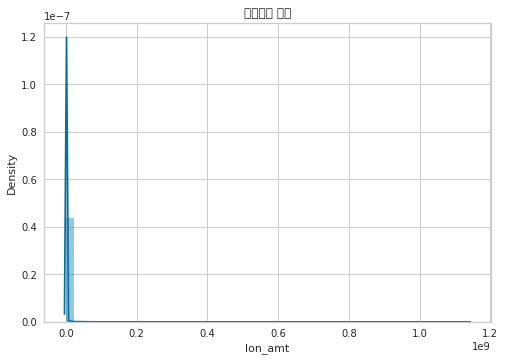

In [82]:
sns.distplot(cus_bnc_loan['lon_amt'])
plt.title('대출금액 분포')

- 대출 금액의 분포가 지나치게 0에 집중되어 있어, 분류에 있어서 유의미하지 않은 결과를 도출할 것으로 판단
- 전체 투자금액 대비 대출금액 변수 삭제

# 분류 모델링

## 분류 모델링을 위한 데이터 프레임 종합하기

In [83]:
cus_std.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57531 entries, 0 to 57530
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   act_no      57531 non-null  object 
 1   bse_ym      57531 non-null  int64  
 2   dist_index  57531 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.3+ MB


In [84]:
tot_var_index = tot_var_index.rename( columns = {'total' : 'total_var_index'})
tot_var_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46230 entries, 0 to 46229
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   act_no           46230 non-null  object 
 1   bse_ym           46230 non-null  object 
 2   total_var_index  46230 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [85]:
# 필요한 칼럼만 추출
cus_copy = cus.copy()
cus_copy = cus[['act_no', 'bse_ym', 'cus_aet_stn_cd', 'lsg_sgm_cd', 'tot_ivs_te_sgm_cd', 'mrz_mkt_dit_cd', 'mrz_btp_dit_cd', 'aet_bse_stk_trd_tp_cd']]

In [86]:
cus_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59081 entries, 0 to 59080
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   act_no                 59081 non-null  object 
 1   bse_ym                 59081 non-null  int64  
 2   cus_aet_stn_cd         59081 non-null  int64  
 3   lsg_sgm_cd             59081 non-null  int64  
 4   tot_ivs_te_sgm_cd      59081 non-null  int64  
 5   mrz_mkt_dit_cd         57819 non-null  float64
 6   mrz_btp_dit_cd         57819 non-null  float64
 7   aet_bse_stk_trd_tp_cd  57819 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 3.6+ MB


- 국내 only_ko 집단 데이터프레임 병합

In [87]:
only_ko_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46230 entries, 0 to 46229
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   act_no       46230 non-null  object
 1   bse_ym       46230 non-null  int64 
 2   orr_tot_cnt  46230 non-null  int64 
 3   iem_cnt      46230 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ MB


In [88]:
# 데이터프레임 merge
only_ko_df_final1 = pd.merge(only_ko_df, cus_std, how = 'inner', on = ['act_no', 'bse_ym'])
only_ko_df_final1['bse_ym'] = only_ko_df_final1['bse_ym'].astype('string')
only_ko_df_final2 = pd.merge(only_ko_df_final1, tot_var_index, how = 'inner', on = ['act_no', 'bse_ym'])
cus_copy['bse_ym'] = cus_copy['bse_ym'].astype('string')
only_ko_df_final = pd.merge(only_ko_df_final2, cus_copy, how = 'inner', on = ['act_no', 'bse_ym'] )

# 최종 only_ko 데이터프레임
only_ko_df_final

,act_no,bse_ym,orr_tot_cnt,iem_cnt,dist_index,total_var_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,1,4,0.048171,1.837142,2,1,1,6.0,16.0,5.0
1,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202202,1,5,0.065974,3.477071,2,1,1,2.0,10.0,5.0
2,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202203,1,4,0.049125,0.940831,2,1,2,6.0,16.0,5.0
3,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202204,1,4,0.039952,4.431948,2,1,2,6.0,16.0,5.0
4,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202205,1,4,0.030148,5.685369,2,1,2,6.0,16.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
46225,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202202,1,1,1.000000,0.000000,1,2,1,6.0,16.0,5.0
46226,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202203,1,1,1.000000,0.000000,1,2,1,6.0,16.0,5.0
46227,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202204,1,1,1.000000,0.000000,1,2,1,6.0,16.0,5.0
46228,ffff314cc371dd13571dbde2fc9355e142b8e88d4b9790...,202205,1,1,1.000000,0.000000,1,2,1,6.0,16.0,5.0


- 해외 only_oss 집단 데이터프레임 병합

In [89]:
only_oss_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3423 entries, 0 to 3422
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   act_no       3423 non-null   object
 1   bse_ym       3423 non-null   int64 
 2   orr_tot_cnt  3423 non-null   int64 
 3   iem_cnt      3423 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 133.7+ KB


In [90]:
# 데이터프레임 merge
only_oss_df_final1 = pd.merge(only_oss_df, cus_std, how = 'inner', on = ['act_no', 'bse_ym'])
only_oss_df_final1['bse_ym'] = only_oss_df_final1['bse_ym'].astype('string')
cus_copy['bse_ym'] = cus_copy['bse_ym'].astype('string')
only_oss_df_final = pd.merge(only_oss_df_final1, cus_copy, how = 'inner', on = ['act_no', 'bse_ym'] )

# 최종 only_ko 데이터프레임
only_oss_df_final

,act_no,bse_ym,orr_tot_cnt,iem_cnt,dist_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd
0,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202201,2,1,1.000000,2,1,1,6.0,16.0,4.0
1,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202202,1,1,1.000000,2,1,1,6.0,16.0,4.0
2,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202203,1,1,1.000000,2,1,1,6.0,16.0,4.0
3,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202204,1,1,1.000000,2,1,1,6.0,16.0,4.0
4,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202205,1,1,1.000000,2,1,1,6.0,16.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...
3418,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202202,1,1,1.000000,2,2,1,6.0,16.0,4.0
3419,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202203,3,2,0.676021,2,2,1,6.0,16.0,4.0
3420,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202204,1,2,0.684589,2,2,1,6.0,16.0,4.0
3421,ff72580db39e0be8adbdf3237ce3c4718b06faf9e77c18...,202205,1,2,0.689793,2,2,1,6.0,16.0,4.0


- 모두 투자 both 집단 데이터프레임 병합

In [91]:
both_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7150 entries, 0 to 7149
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   act_no       7150 non-null   object 
 1   bse_ym       7150 non-null   int64  
 2   orr_tot_cnt  7150 non-null   int64  
 3   kr_ratio     7149 non-null   float64
 4   oss_ratio    7149 non-null   float64
 5   sum          7150 non-null   float64
 6   iem_cnt      7150 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 446.9+ KB


In [92]:
# 데이터프레임 merge
both_df_final1 = pd.merge(both_df, cus_std, how = 'inner', on = ['act_no', 'bse_ym'])
both_df_final1['bse_ym'] = both_df_final1['bse_ym'].astype('string')
cus_copy['bse_ym'] = cus_copy['bse_ym'].astype('string')
both_df_final = pd.merge(both_df_final1, cus_copy, how = 'inner', on = ['act_no', 'bse_ym'] )
both_df_final

,act_no,bse_ym,orr_tot_cnt,kr_ratio,oss_ratio,sum,iem_cnt,dist_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,2,39.0,61.0,97221305.0,45,0.030670,5,5,3,6.0,16.0,2.0
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,2,40.0,60.0,98926902.0,45,0.031033,5,5,3,6.0,16.0,2.0
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,2,38.0,62.0,106077949.0,45,0.032098,5,5,3,6.0,16.0,2.0
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,2,40.0,60.0,97304233.0,46,0.030293,5,5,3,6.0,16.0,2.0
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,2,40.0,60.0,95933153.0,46,0.029279,5,5,3,6.0,16.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7145,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,4,100.0,0.0,9271101.0,5,0.266748,2,2,2,1.0,9.0,4.0
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,2,100.0,0.0,8728564.0,4,0.323778,2,2,2,1.0,9.0,4.0
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,2,100.0,0.0,8277014.0,4,0.333475,2,2,3,6.0,16.0,4.0
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,2,100.0,0.0,8296357.0,4,0.332451,2,2,3,6.0,16.0,4.0


In [93]:
# 불필요한 칼럼 제외
both_df_final = both_df_final.drop(['oss_ratio', 'sum'], axis ='columns')


# 최종 only_ko 데이터프레임
both_df_final

,act_no,bse_ym,orr_tot_cnt,kr_ratio,iem_cnt,dist_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,mrz_btp_dit_cd,aet_bse_stk_trd_tp_cd
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,2,39.0,45,0.030670,5,5,3,6.0,16.0,2.0
1,006a40eb47e715b024fa240562196ab2bb94db59870303...,202202,2,40.0,45,0.031033,5,5,3,6.0,16.0,2.0
2,006a40eb47e715b024fa240562196ab2bb94db59870303...,202203,2,38.0,45,0.032098,5,5,3,6.0,16.0,2.0
3,006a40eb47e715b024fa240562196ab2bb94db59870303...,202204,2,40.0,46,0.030293,5,5,3,6.0,16.0,2.0
4,006a40eb47e715b024fa240562196ab2bb94db59870303...,202205,2,40.0,46,0.029279,5,5,3,6.0,16.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7145,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202202,4,100.0,5,0.266748,2,2,2,1.0,9.0,4.0
7146,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202203,2,100.0,4,0.323778,2,2,2,1.0,9.0,4.0
7147,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202204,2,100.0,4,0.333475,2,2,3,6.0,16.0,4.0
7148,ff9381962b31de8003bc7af231a2b09ff7d7ede32f0af3...,202205,2,100.0,4,0.332451,2,2,3,6.0,16.0,4.0


In [94]:
only_ko_df['act_no'].nunique() # only_ko 집단의 고유 계좌 수

8189

In [95]:
only_oss_df['act_no'].nunique() # only_oss 집단의 고유 계좌 수

699

In [96]:
both_df_final['act_no'].nunique() # both 집단의 고유 계좌 수

1376

In [97]:
# 병합한 데이터들을 csv파일로 저장
only_ko_df_final.to_csv('only_ko_df_final.csv', index = False)
only_oss_df_final.to_csv('only_oss_df_final.csv', index = False)
both_df_final.to_csv('both_df_final.csv', index = False)

## 최종 변수 선정

- 변수 선정 기준
  * 서비스 목표인 '투자, 건강한 문화가 되다.'를 실현하기 위한 수치형, 범주형 변수들을 종합적으로 고려
  * 다중공선성과 이상치를 고려하여 변수 선정
  * 데이터 분포가 유의미하다고 판단되는 변수 선정

**- 국내집단 only_ko 의 경우 :**
  * 분산투자 지수 dist_index
  * 변동성 지수 total_var_index
  * 총 거래횟수 orr_tot_cnt
  * 총 보유종목 수 iem_cnt
  * 그 외 cus_info 데이터프레임에 존재하는 변수
   *  : 고객자산구간코드, LIFESTAGE세그먼트코드, 총투자기간세그먼트코드, 주거래시장구분코드

**- 해외집단 only_oss 의 경우 :**
  * 분산투자 지수 dist_index
  * 총 거래횟수 orr_tot_cnt
  * 총 보유종목 수 iem_cnt
  * 그 외 cus_info 데이터프레임에 존재하는 변수
   *  : 고객자산구간코드, LIFESTAGE세그먼트코드, 총투자기간세그먼트코드, 주거래시장구분코드

**- 모두집단 both 의 경우 :**
  * 분산투자 지수 dist_index
  * 국내/해외주식 투자 비율 변수 kr_ratio
  * 총 거래횟수 orr_tot_cnt
  * 총 보유종목 수 iem_cnt
  * 그 외 cus_info 데이터프레임에 존재하는 변수
   *  : 고객자산구간코드, LIFESTAGE세그먼트코드, 총투자기간세그먼트코드, 주거래시장구분코드

## 모델 학습 전, 변수 전처리

### 1. 다중공선성 확인 및 처리
- Heatmap에서 나타나는 절대값이 1에 가까울수록 높은 상관관계를 보임
- 높은 상관관계를 보이는 변수는 둘 중에 하나만 선택

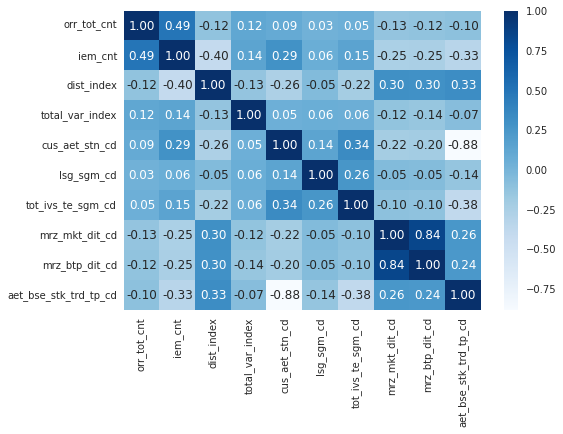

In [98]:
# only_ko 의 경우
sns.heatmap(only_ko_df_final.corr(), annot = True, fmt = '.2f', cmap = 'Blues')

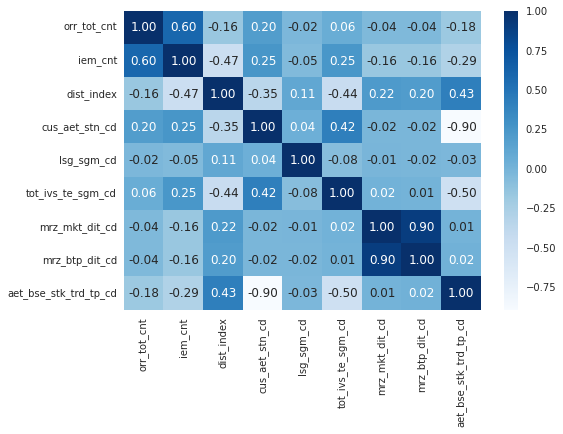

In [99]:
# only_oss의 경우
sns.heatmap(only_oss_df_final.corr(), annot = True, fmt = '.2f', cmap = 'Blues')

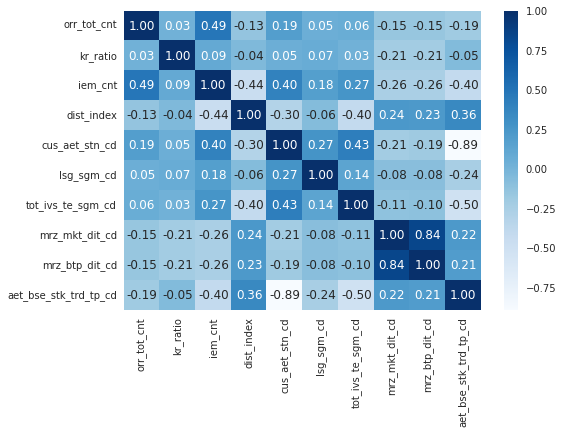

In [100]:
# both의 경우
sns.heatmap(both_df_final.corr(), annot = True, fmt = '.2f', cmap = 'Blues')

- 변수 간 상관관계 분석 결과, 상관관계가 높게 나타난 변수는 다음과 같음
- 'mrz_btp_dit_cd', 'mrz_mkt_dit_cd'
- 'cus_aet_stn_cd', 'aet_bse_stk_trdtp_cd'

- 따라서 각 변수들 중 하나는 삭제
- **삭제할 변수 : 'aet_bse_stk_trd_tp_cd', 'mrz_btp_dit_cd'**

- 변수 삭제

In [101]:
only_ko_df_final = only_ko_df_final.drop([ 'aet_bse_stk_trd_tp_cd', 'mrz_btp_dit_cd'], axis ='columns')
only_oss_df_final = only_oss_df_final.drop([ 'aet_bse_stk_trd_tp_cd', 'mrz_btp_dit_cd'], axis ='columns')
both_df_final = both_df_final.drop([ 'aet_bse_stk_trd_tp_cd', 'mrz_btp_dit_cd'], axis ='columns')

### 2. 데이터 이상치 처리
  * 데이터 안에 inf, 99, nan은 이상치로 판단

In [102]:
def del_df(df):
    del_list = []
    for i in tqdm(df.columns):
        del_list += list(df[df[i].isin([99, np.inf, -np.inf , np.nan])].index)

    new_df = df.drop(del_list).copy()
    new_df.reset_index(drop=True,inplace=True)
    return new_df


only_ko_df_final = del_df(only_ko_df_final)
only_oss_df_final = del_df(only_oss_df_final)
both_df_final = del_df(both_df_final)

100%|██████████| 10/10 [00:00<00:00, 581.06it/s]


### 모든 집단의 데이터프레임을 월별로 분할

In [103]:
# 범주형 변수들은 dtype을 object로 변경
only_ko_df_final['cus_aet_stn_cd'] = only_ko_df_final['cus_aet_stn_cd'].astype(object)
only_ko_df_final['lsg_sgm_cd'] = only_ko_df_final['lsg_sgm_cd'].astype(object)
only_ko_df_final['tot_ivs_te_sgm_cd'] = only_ko_df_final['tot_ivs_te_sgm_cd'].astype(object)
only_ko_df_final['mrz_mkt_dit_cd'] = only_ko_df_final['mrz_mkt_dit_cd'].astype(object)

In [104]:
# 범주형 변수들은 dtype을 object로 변경
only_oss_df_final['cus_aet_stn_cd'] = only_oss_df_final['cus_aet_stn_cd'].astype(object)
only_oss_df_final['lsg_sgm_cd'] = only_oss_df_final['lsg_sgm_cd'].astype(object)
only_oss_df_final['tot_ivs_te_sgm_cd'] = only_oss_df_final['tot_ivs_te_sgm_cd'].astype(object)
only_oss_df_final['mrz_mkt_dit_cd'] = only_oss_df_final['mrz_mkt_dit_cd'].astype(object)

In [105]:
# 범주형 변수들은 dtype을 object로 변경
both_df_final['cus_aet_stn_cd'] = both_df_final['cus_aet_stn_cd'].astype(object)
both_df_final['lsg_sgm_cd'] = both_df_final['lsg_sgm_cd'].astype(object)
both_df_final['tot_ivs_te_sgm_cd'] = both_df_final['tot_ivs_te_sgm_cd'].astype(object)
both_df_final['mrz_mkt_dit_cd'] = both_df_final['mrz_mkt_dit_cd'].astype(object)

- 국내 only_ko 집단 월별로 데이터프레임 나누기

In [106]:
only_ko_jan = only_ko_df_final[only_ko_df_final['bse_ym'] == '202201']
only_ko_feb = only_ko_df_final[only_ko_df_final['bse_ym'] == '202202']
only_ko_mar = only_ko_df_final[only_ko_df_final['bse_ym'] == '202203']
only_ko_apr = only_ko_df_final[only_ko_df_final['bse_ym'] == '202204']
only_ko_may = only_ko_df_final[only_ko_df_final['bse_ym'] == '202205']
only_ko_jun = only_ko_df_final[only_ko_df_final['bse_ym'] == '202206']

- 해외 only_oss 집단 월별로 데이터프레임 나누기

In [107]:
only_oss_jan = only_oss_df_final[only_oss_df_final['bse_ym'] == '202201']
only_oss_feb = only_oss_df_final[only_oss_df_final['bse_ym'] == '202202']
only_oss_mar = only_oss_df_final[only_oss_df_final['bse_ym'] == '202203']
only_oss_apr = only_oss_df_final[only_oss_df_final['bse_ym'] == '202204']
only_oss_may = only_oss_df_final[only_oss_df_final['bse_ym'] == '202205']
only_oss_jun = only_oss_df_final[only_oss_df_final['bse_ym'] == '202206']

- 모두 both 집단 월별로 데이터프레임 나누기

In [108]:
both_jan = both_df_final[both_df_final['bse_ym'] == '202201']
both_feb = both_df_final[both_df_final['bse_ym'] == '202202']
both_mar = both_df_final[both_df_final['bse_ym'] == '202203']
both_apr = both_df_final[both_df_final['bse_ym'] == '202204']
both_may = both_df_final[both_df_final['bse_ym'] == '202205']
both_jun = both_df_final[both_df_final['bse_ym'] == '202206']

### 3. 변수값 스케일링 진행 


- 변수를 표준화하여 변수의 중요도를 비슷하게 만들어줌.

In [109]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

- 스케일링을 할 수치형 변수들만 리스트로 저장

In [110]:
# only_ko 경우
x1 = ['orr_tot_cnt', 'iem_cnt', 'dist_index', 'total_var_index']

# only_oss 경우
x2 = ['orr_tot_cnt', 'iem_cnt', 'dist_index']

# both 경우
x3 = ['orr_tot_cnt', 'iem_cnt', 'dist_index', 'kr_ratio']

In [111]:
sc = StandardScaler()

#### 국내 only_ko 경우

In [112]:
# 국내 only_ko 의 1월인 경우
only_ko_jan[x1] = sc.fit_transform(only_ko_jan[x1])
only_ko_jan[x1] = pd.DataFrame(only_ko_jan[x1])
only_ko_jan[x1].columns = x1

In [113]:
# 국내 only_ko 의 2월인 경우
only_ko_feb[x1] = sc.fit_transform(only_ko_feb[x1])
only_ko_feb[x1] = pd.DataFrame(only_ko_feb[x1])
only_ko_feb[x1].columns = x1

In [114]:
# 국내 only_ko 의 3월인 경우
only_ko_mar[x1] = sc.fit_transform(only_ko_mar[x1])
only_ko_mar[x1] = pd.DataFrame(only_ko_mar[x1])
only_ko_mar[x1].columns = x1

In [115]:
# 국내 only_ko 의 4월인 경우
only_ko_apr[x1] = sc.fit_transform(only_ko_apr[x1])
only_ko_apr[x1] = pd.DataFrame(only_ko_apr[x1])
only_ko_apr[x1].columns = x1

In [116]:
# 국내 only_ko 의 5월인 경우
only_ko_may[x1] = sc.fit_transform(only_ko_may[x1])
only_ko_may[x1] = pd.DataFrame(only_ko_may[x1])
only_ko_may[x1].columns = x1

In [117]:
# 국내 only_ko 의 6월인 경우
only_ko_jun[x1] = sc.fit_transform(only_ko_jun[x1])
only_ko_jun[x1] = pd.DataFrame(only_ko_jun[x1])
only_ko_jun[x1].columns = x1

#### 해외 only_oss 경우

In [118]:
# 해외 only_oss 의 1월인 경우
only_oss_jan[x2] = sc.fit_transform(only_oss_jan[x2])
only_oss_jan[x2] = pd.DataFrame(only_oss_jan[x2])
only_oss_jan[x2].columns = x2

In [119]:
# 해외 only_oss 의 2월인 경우
only_oss_feb[x2] = sc.fit_transform(only_oss_feb[x2])
only_oss_feb[x2] = pd.DataFrame(only_oss_feb[x2])
only_oss_feb[x2].columns = x2

In [120]:
# 해외 only_oss 의 3월인 경우
only_oss_mar[x2] = sc.fit_transform(only_oss_mar[x2])
only_oss_mar[x2] = pd.DataFrame(only_oss_mar[x2])
only_oss_mar[x2].columns = x2

In [121]:
# 해외 only_oss 의 4월인 경우
only_oss_apr[x2] = sc.fit_transform(only_oss_apr[x2])
only_oss_apr[x2] = pd.DataFrame(only_oss_apr[x2])
only_oss_apr[x2].columns = x2

In [122]:
# 해외 only_oss 의 5월인 경우
only_oss_may[x2] = sc.fit_transform(only_oss_may[x2])
only_oss_may[x2] = pd.DataFrame(only_oss_may[x2])
only_oss_may[x2].columns = x2

In [123]:
# 해외 only_oss 의 6월인 경우
only_oss_jun[x2] = sc.fit_transform(only_oss_jun[x2])
only_oss_jun[x2] = pd.DataFrame(only_oss_jun[x2])
only_oss_jun[x2].columns = x2

#### 3. 모두 both 그룹의 경우

In [124]:
# 모두 both 의 1월인 경우
both_jan[x3] = sc.fit_transform(both_jan[x3])
both_jan[x3] = pd.DataFrame(both_jan[x3])
both_jan[x3].columns = x3

In [125]:
# 모두 both 의 2월인 경우
both_feb[x3] = sc.fit_transform(both_feb[x3])
both_feb[x3] = pd.DataFrame(both_feb[x3])
both_feb[x3].columns = x3

In [126]:
# 모두 both 의 3월인 경우
both_mar[x3] = sc.fit_transform(both_mar[x3])
both_mar[x3] = pd.DataFrame(both_mar[x3])
both_mar[x3].columns = x3

In [127]:
# 모두 both 의 4월인 경우
both_apr[x3] = sc.fit_transform(both_apr[x3])
both_apr[x3] = pd.DataFrame(both_apr[x3])
both_apr[x3].columns = x3

In [128]:
# 모두 both 의 5월인 경우
both_may[x3] = sc.fit_transform(both_may[x3])
both_may[x3] = pd.DataFrame(both_may[x3])
both_may[x3].columns = x3

In [129]:
# 모두 both 의 6월인 경우
both_jun[x3] = sc.fit_transform(both_jun[x3])
both_jun[x3] = pd.DataFrame(both_jun[x3])
both_jun[x3].columns = x3

- 아래 후술할 KPrototypes 모델링을 위해 데이터프레임을 Matrix로 변환

In [130]:
# only_ko 집단 matrix 변환
kom1 = only_ko_jan.to_numpy()
kom2 = only_ko_feb.to_numpy()
kom3 = only_ko_mar.to_numpy()
kom4 = only_ko_apr.to_numpy()
kom5 = only_ko_may.to_numpy()
kom6 = only_ko_jun.to_numpy()

In [131]:
# only_oss 집단 matrix 변환
osm1 = only_oss_jan.to_numpy()
osm2 = only_oss_feb.to_numpy()
osm3 = only_oss_mar.to_numpy()
osm4 = only_oss_apr.to_numpy()
osm5 = only_oss_may.to_numpy()
osm6 = only_oss_jun.to_numpy()

In [132]:
# both 집단 matrix 변환
bm1 = both_jan.to_numpy()
bm2 = both_feb.to_numpy()
bm3 = both_mar.to_numpy()
bm4 = both_apr.to_numpy()
bm5 = both_may.to_numpy()
bm6 = both_jun.to_numpy()

## 분류모델 학습

- 사용한 분류 모델 : kmodes 패키지의 **KPrototypes**
- 모델 선정 이유
  * 분류 기준으로 선정한 변수들의 type은 다음과 같이 두 가지로 나뉨
    * 수치형 변수 : 'orr_tot_cnt',
 'iem_cnt',
 'dist_index',
 'total_var_index'
    * 범주형 변수 : 'cus_aet_stn_cd',
 'lsg_sgm_cd',
 'tot_ivs_te_sgm_cd',
 'mrz_mkt_dit_cd'

  * **기존 Kmeans 모델**은 수치형 변수와 범주형 변수를 모두 반영하지 못하고 **오직 수치형 변수들에 의해 분류를 진행**하기 때문에, 
  * **수치형 변수와 범주형 변수 모두를 고려하여 분류**할 수 있는 모델인 **KPrototypes를 사용**

In [133]:
!pip install kmodes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
# 필요한 모듈 불러오기
from kmodes.kprototypes import KPrototypes
from plotnine import *
import plotnine

### 1. 국내 only_ko 모델링

#### 1-1 모델링 진행

- case1) 고객정보기준년월 : 202201

In [135]:
only_ko_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7380 entries, 0 to 46125
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_no             7380 non-null   object 
 1   bse_ym             7380 non-null   object 
 2   orr_tot_cnt        7380 non-null   float64
 3   iem_cnt            7380 non-null   float64
 4   dist_index         7380 non-null   float64
 5   total_var_index    7380 non-null   float64
 6   cus_aet_stn_cd     7380 non-null   object 
 7   lsg_sgm_cd         7380 non-null   object 
 8   tot_ivs_te_sgm_cd  7380 non-null   object 
 9   mrz_mkt_dit_cd     7380 non-null   object 
dtypes: float64(4), object(6)
memory usage: 634.2+ KB


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


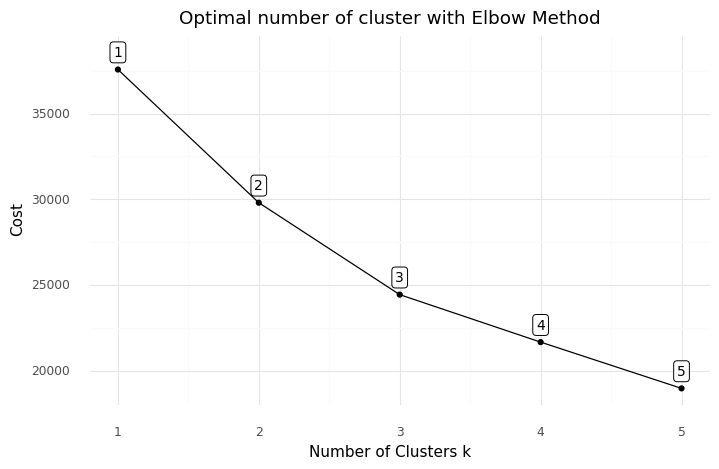

<ggplot: (8765410725373)>

In [136]:
# 최적 K 개수 찾기 위한 Elbow method
cost = []
for cluster in range(1, 6):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(kom1[:,2:], categorical = [4,5,6,7])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
df_cost.head()

# Data 시각화
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [137]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(kom1[:,2:], categorical = [4,5,6,7])

array([1, 0, 1, ..., 1, 2, 2], dtype=uint16)

#### 1-2 모델링 결과 확인

In [138]:
# 클러스터링 결과를 데이터프레임에 추가
only_ko_jan['cluster_id'] = kprototype.labels_ 

In [139]:
only_ko_jan

,act_no,bse_ym,orr_tot_cnt,iem_cnt,dist_index,total_var_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,cluster_id
0,0000b53f15d9484a62a745bdb02cd5f27796ba07c1bddc...,202201,-0.141704,-0.221782,-0.982287,-1.504603,2,1,1,6.0,1
6,00086aa946369d1c75182dffd43bd4a34f3abc1ddeba03...,202201,1.980929,2.495908,-0.985610,2.698435,1,9,3,2.0,0
19,0036c57441034bbb6b5a9618d3ff6a1ec9734b78327c7e...,202201,-0.141704,0.382149,-0.847547,-1.235019,2,4,3,6.0,1
25,003b998c70775d3f079d89ed932345ef3276d2a35d93a5...,202201,0.161529,1.992632,-0.961057,0.270812,4,9,3,1.0,1
31,0041e009e19878cd52dca944d43ab4a0492ea981425bc6...,202201,-0.081057,-0.121127,-0.391067,-0.385148,1,3,3,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...
46101,ffce5f2a556e2192467333e9d9e2e141daa83f78eea428...,202201,-0.141704,-0.423093,0.858019,1.164605,1,7,1,6.0,2
46107,ffd96d859770d62800f6f654fce913c50f9cbf809efcc8...,202201,-0.141704,-0.523748,1.676025,-1.159325,1,4,2,6.0,2
46113,ffdb8a101b04d93c8b09ddce17a7be84d0179908f3f4cc...,202201,-0.111381,-0.423093,-0.651477,2.810497,1,5,2,2.0,1
46119,ffef6c11a934db569dc44858114b219b0ea6fb21d59f63...,202201,-0.141704,-0.523748,1.676025,-1.814266,1,8,1,6.0,2


In [140]:
only_ko_jan['cluster_id'].value_counts()

1    5104
2    2145
0     131
Name: cluster_id, dtype: int64

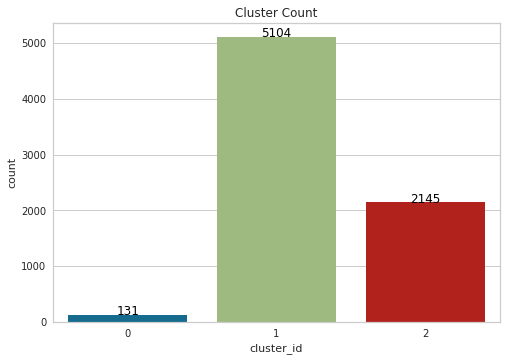

In [141]:
# 클러스터링 결과 시각화
ax=sns.countplot(x=only_ko_jan['cluster_id'])
for index, row in pd.DataFrame(only_ko_jan['cluster_id'].value_counts()).iterrows():
    ax.text(index,row.values[0], str(round(row.values[0])),color='black', ha="center")
    #print(index,row.values[0])
plt.title('Cluster Count')
plt.show()

### 2. 해외 only_oss 모델링

#### 2-1 모델링 진행

- case1) 고객정보기준년월 : 202201

In [142]:
only_oss_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 0 to 3417
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_no             534 non-null    object 
 1   bse_ym             534 non-null    string 
 2   orr_tot_cnt        534 non-null    float64
 3   iem_cnt            534 non-null    float64
 4   dist_index         534 non-null    float64
 5   cus_aet_stn_cd     534 non-null    object 
 6   lsg_sgm_cd         534 non-null    object 
 7   tot_ivs_te_sgm_cd  534 non-null    object 
 8   mrz_mkt_dit_cd     534 non-null    object 
dtypes: float64(3), object(5), string(1)
memory usage: 41.7+ KB


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


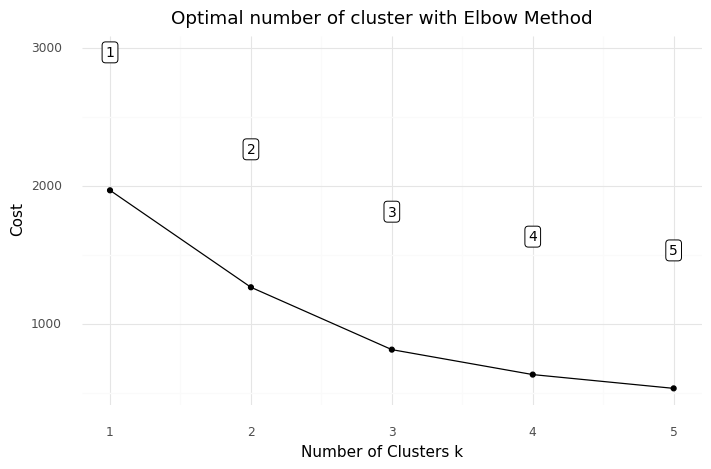

<ggplot: (8765410174329)>

In [143]:
# 최적 K 개수 찾기 위한 Elbow method
cost = []
for cluster in range(1, 6):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(osm1[:,2:], categorical = [3,4,5,6])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
df_cost.head()

# Data 시각화
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [144]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(osm1[:,2:], categorical = [3,4,5,6])

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,

#### 2-2 모델링 결과 확인

In [145]:
# 클러스터링 결과를 데이터프레임에 추가
only_oss_jan['cluster_id'] = kprototype.labels_ 

In [146]:
only_oss_jan

,act_no,bse_ym,orr_tot_cnt,iem_cnt,dist_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,cluster_id
0,00c96a6ca1dba7fd06b542958a0e741b4199954b2fe4be...,202201,-0.099871,-0.539387,0.898649,2,1,1,6.0,0
6,00daa8a451fe230ba9e055c48a34325ac0c61efdd5427d...,202201,-0.128981,0.051449,-0.886008,1,2,3,6.0,1
12,01e9e2ec9a9c2babbf05e462282031ce2cb27d26e83b75...,202201,-0.128981,-0.539387,0.898649,1,1,1,6.0,0
18,02446903037bdcfe7d150e68d223798b95cfcd164981ce...,202201,-0.128981,-0.243969,-0.208208,1,5,1,2.0,0
24,025d0047e8e1fdb1594a91595994ce8f28415e60ea4b49...,202201,-0.128981,-0.539387,0.898649,1,4,3,6.0,0
...,...,...,...,...,...,...,...,...,...,...
3381,f92a98c890446481ac36125b21ca5ab4c378063737becb...,202201,-0.099871,-0.243969,-1.523927,2,5,3,6.0,1
3386,f9eee59de140d10d61340e025c8e898cb0dc71619c2cb0...,202201,-0.128981,-0.539387,0.898649,1,5,1,6.0,0
3398,fd7eccca263500ae6c403293fe24cdd17570e5ab3a78a1...,202201,-0.128981,-0.539387,0.898649,1,7,1,6.0,0
3409,fef02c79726a4b12e751512eb934c45293ef4e6e84ccef...,202201,-0.128981,0.642286,-0.903992,1,6,1,6.0,1


In [147]:
only_oss_jan['cluster_id'].value_counts()

0    318
1    213
2      3
Name: cluster_id, dtype: int64

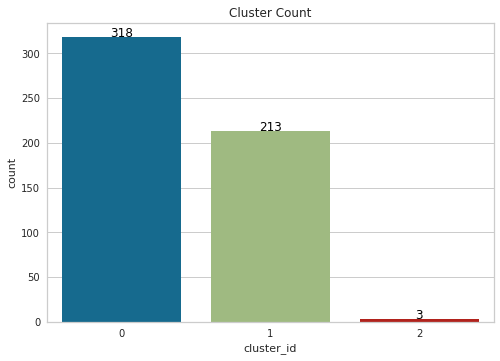

In [148]:
# 클러스터링 결과 시각화
ax=sns.countplot(x=only_oss_jan['cluster_id'])
for index, row in pd.DataFrame(only_oss_jan['cluster_id'].value_counts()).iterrows():
    ax.text(index,row.values[0], str(round(row.values[0])),color='black', ha="center")
    #print(index,row.values[0])
plt.title('Cluster Count')
plt.show()

### 3. 모두 both 모델링

#### 3-1 모델링 진행

- case1) 고객정보기준년월 : 202201

In [149]:
both_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 6713
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_no             1043 non-null   object 
 1   bse_ym             1043 non-null   string 
 2   orr_tot_cnt        1043 non-null   float64
 3   kr_ratio           1043 non-null   float64
 4   iem_cnt            1043 non-null   float64
 5   dist_index         1043 non-null   float64
 6   cus_aet_stn_cd     1043 non-null   object 
 7   lsg_sgm_cd         1043 non-null   object 
 8   tot_ivs_te_sgm_cd  1043 non-null   object 
 9   mrz_mkt_dit_cd     1043 non-null   object 
dtypes: float64(4), object(5), string(1)
memory usage: 89.6+ KB


Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5


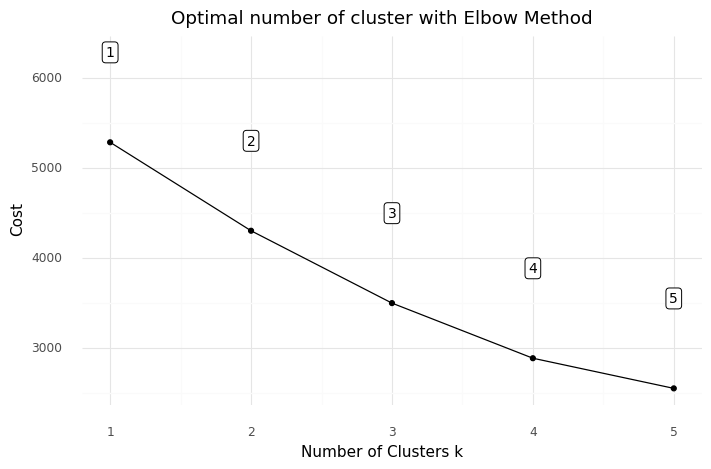

<ggplot: (8765410180537)>

In [150]:
# 최적 K 개수 찾기 위한 Elbow method
cost = []
for cluster in range(1, 6):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(bm1[:,2:], categorical = [4,5,6,7])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break

df_cost = pd.DataFrame({'Cluster':range(1, 6), 'Cost':cost})
df_cost.head()

# Data 시각화
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

In [151]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(bm1[:,2:], categorical = [4,5,6,7])

array([2, 0, 0, ..., 3, 2, 0], dtype=uint16)

#### 3-2 모델링 결과 확인

In [152]:
# 클러스터링 결과를 데이터프레임에 추가
both_jan['cluster_id'] = kprototype.labels_ 

In [153]:
both_jan

,act_no,bse_ym,orr_tot_cnt,kr_ratio,iem_cnt,dist_index,cus_aet_stn_cd,lsg_sgm_cd,tot_ivs_te_sgm_cd,mrz_mkt_dit_cd,cluster_id
0,006a40eb47e715b024fa240562196ab2bb94db59870303...,202201,-0.240360,-0.820630,2.986612,-0.979701,5,5,3,6.0,2
10,0144ac7b999a0b4bda86a69a542a9d47eb16792d9c8966...,202201,-0.157878,0.934069,-0.143029,-0.517883,2,4,4,1.0,0
16,01b5cea602f2495e716897e72ddac5856f909531c50a5a...,202201,-0.207367,0.808733,-0.056095,-0.440754,2,6,3,1.0,0
22,02020fe47394b560b3938681816006b6ef51722420af5a...,202201,-0.240360,-0.256619,-0.490767,-0.052667,1,2,2,6.0,2
31,02a70f8ddd0d1613beb60bc8c2e671df0f994de6d1832e...,202201,-0.025907,-1.666645,0.030840,-0.899640,1,4,3,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...
6694,fe79b2dd2f3427144c5e7a133711ca177998d06a38d645...,202201,-0.240360,0.996736,0.726315,-0.552615,1,4,3,6.0,0
6700,fec61e97b6076b294e89d19d52f81c7bc181e9c54e1b58...,202201,-0.190871,-1.541309,0.378578,-0.840625,2,5,2,1.0,2
6706,ff129f25aae4814b037e3bc24baa9d89aa8265cfc89bba...,202201,-0.207367,1.090738,-0.664636,0.942366,1,4,1,1.0,3
6707,ff7aaca74558d3ad51611079e5cd73b69125fb9fa9d5e8...,202201,-0.108389,-2.011318,-0.229964,-0.462475,1,5,2,6.0,2


In [154]:
both_jan['cluster_id'].value_counts()

0    529
2    350
3    137
1     27
Name: cluster_id, dtype: int64

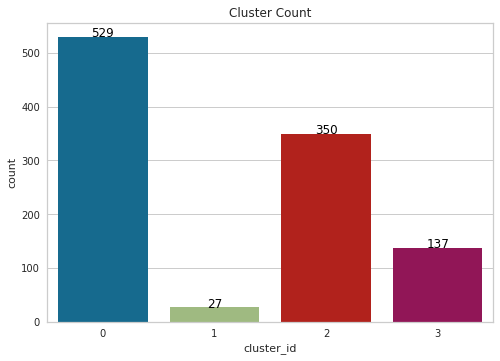

In [155]:
# 클러스터링 결과 시각화
ax=sns.countplot(x=both_jan['cluster_id'])
for index, row in pd.DataFrame(both_jan['cluster_id'].value_counts()).iterrows():
    ax.text(index,row.values[0], str(round(row.values[0])),color='black', ha="center")
    #print(index,row.values[0])
plt.title('Cluster Count')
plt.show()

## 모델링 결과 추론

### 국내 only_ko 그룹, 202201 기준

In [156]:
only_ko_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7380 entries, 0 to 46125
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_no             7380 non-null   object 
 1   bse_ym             7380 non-null   object 
 2   orr_tot_cnt        7380 non-null   float64
 3   iem_cnt            7380 non-null   float64
 4   dist_index         7380 non-null   float64
 5   total_var_index    7380 non-null   float64
 6   cus_aet_stn_cd     7380 non-null   object 
 7   lsg_sgm_cd         7380 non-null   object 
 8   tot_ivs_te_sgm_cd  7380 non-null   object 
 9   mrz_mkt_dit_cd     7380 non-null   object 
 10  cluster_id         7380 non-null   uint16 
dtypes: float64(4), object(6), uint16(1)
memory usage: 906.7+ KB


- 수치형 변수 군집별 분포 시각화
  - orr_tot_cnt
  - iem_cnt
  - dist_index
  - total_var_index

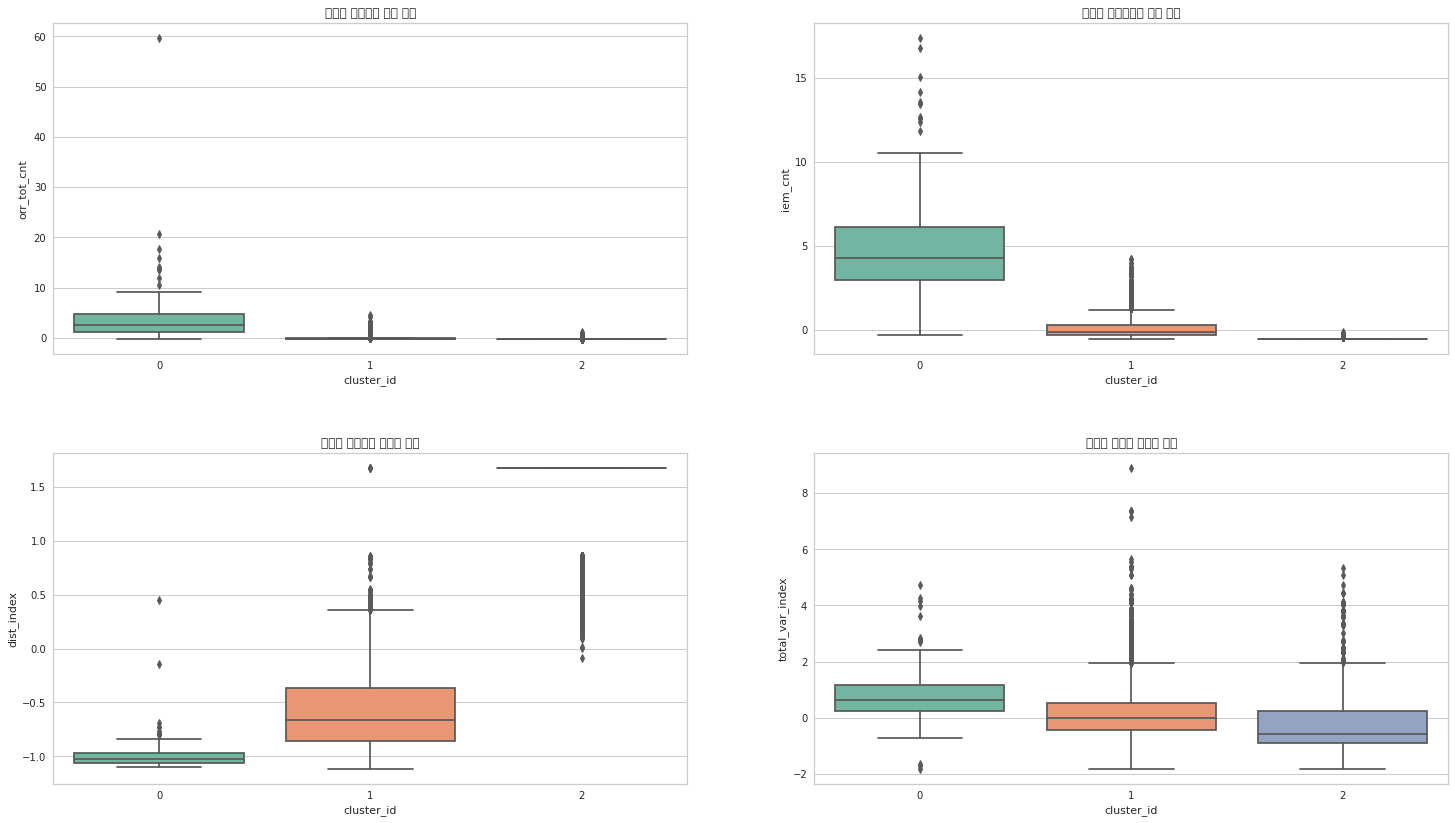

In [157]:
fig,ax=plt.subplots(nrows=2,ncols=2 , figsize=(25,14))
plt.subplots_adjust(wspace=0.2, hspace = 0.3)

p1 = sns.boxplot( data = only_ko_jan, x = 'cluster_id', y = 'orr_tot_cnt', ax = ax[0, 0], palette = 'Set2')
p2 = sns.boxplot( data = only_ko_jan, x = 'cluster_id', y = 'iem_cnt', ax = ax[0, 1], palette = 'Set2')
p3 = sns.boxplot( data = only_ko_jan, x = 'cluster_id', y = 'dist_index', ax = ax[1, 0], palette = 'Set2')
p4 = sns.boxplot( data = only_ko_jan, x = 'cluster_id', y = 'total_var_index', ax = ax[1, 1], palette = 'Set2')

p1.set_title('군집별 거래횟수 합계 분포')
p2.set_title('군집별 보유종목수 합계 분포')
p3.set_title('군집별 분산투자 지수값 분포')
p4.set_title('군집별 변동성 지수값 분포')

sns.set(font_scale=2)

- 202201 기준, 국내주식만하는 only_ko 집단은 3개의 군집으로 분류

&nbsp;

- 0번 군집
  - 평균 거래횟수와 보유종목 수가 많은 편
  - 분산투자 지수값와 변동성 지수값의 중앙값이 낮음
  - 주식 거래를 활발히 이용하며 변동성이 높은 종목에 집중 투자하는 경향

- 1번 군집
  - 평균 거래횟수와 보유종목 수가 적은 편
  - 분산투자 지수값와 변동성 지수값의 중앙값이 높음
  - 주식 거래를 활발하게 이용하지 않으며 위험을 회피하고 안정성을 추구하려는 경향

- 2번 군집
  - 평균 거래횟수와 보유종목 수가 거의 없는 편
  - 분산투자 지수값의 중앙값은 매우 높고 변동성 지수값의 중앙값은 낮음
  - 주식 거래를 거의 이용하지 않으며 위험을 회피하고 안정성을 추구하려는 경향



&nbsp;


> 각 군집의 특성을 파악했을 때 `주식에 관심이 많으며 위험을 감수하며 집중투자를 하는 고객군`, `주식을 활발히 하지는 않지만 주식을 통해 안정적인 수익을 창출하고자 하는 고객군`,`주식에 관심이 없고 안정성을 추구하려는 고객군`으로 분류할 수 있습니다.

- 범주형 변수 군집별 시각화
  - cus_aet_stn_cd     
  - lsg_sgm_cd         
  - tot_ivs_te_sgm_cd
  - mrz_mkt_dit_cd 

In [158]:
def group_plot(df, g, name_list):

  fig, axes = plt.subplots(g,len(name_list),figsize=(50, 12))
  plt.subplots_adjust(wspace=0.3, hspace = 0.5)

  for i in range(g):
    for num in range(len(name_list)):

      if num != len(name_list)-1 :
        plot1 = sns.countplot(x=name_list[num], data=df.loc[df['cluster_id'] == i], order = df.loc[df['cluster_id'] == i][name_list[num]].value_counts().iloc[:5].index[::-1], ax=axes[i, num]) 
        plot1.set_title(f'cluster_id : {i}' + ' ' + name_list[num] ,fontsize=15 , weight='bold')
        plot1.set_xlabel(' ')
        plot1.set_ylabel(' ')

      else:
        plot1 = sns.countplot(x=name_list[num], data=df.loc[df['cluster_id'] == i], order = df.loc[df['cluster_id'] == i][name_list[num]].value_counts().iloc[:5].index[::-1], ax=axes[i, num]) 
        plot1.set_title(f'cluster_id : {i}' + ' ' + name_list[num] ,fontsize=15 , weight='bold')
        plot1.set_xlabel(' ')
        plot1.set_ylabel(' ')
        plot1.set(xticklabels=[])

  

  plt.show()

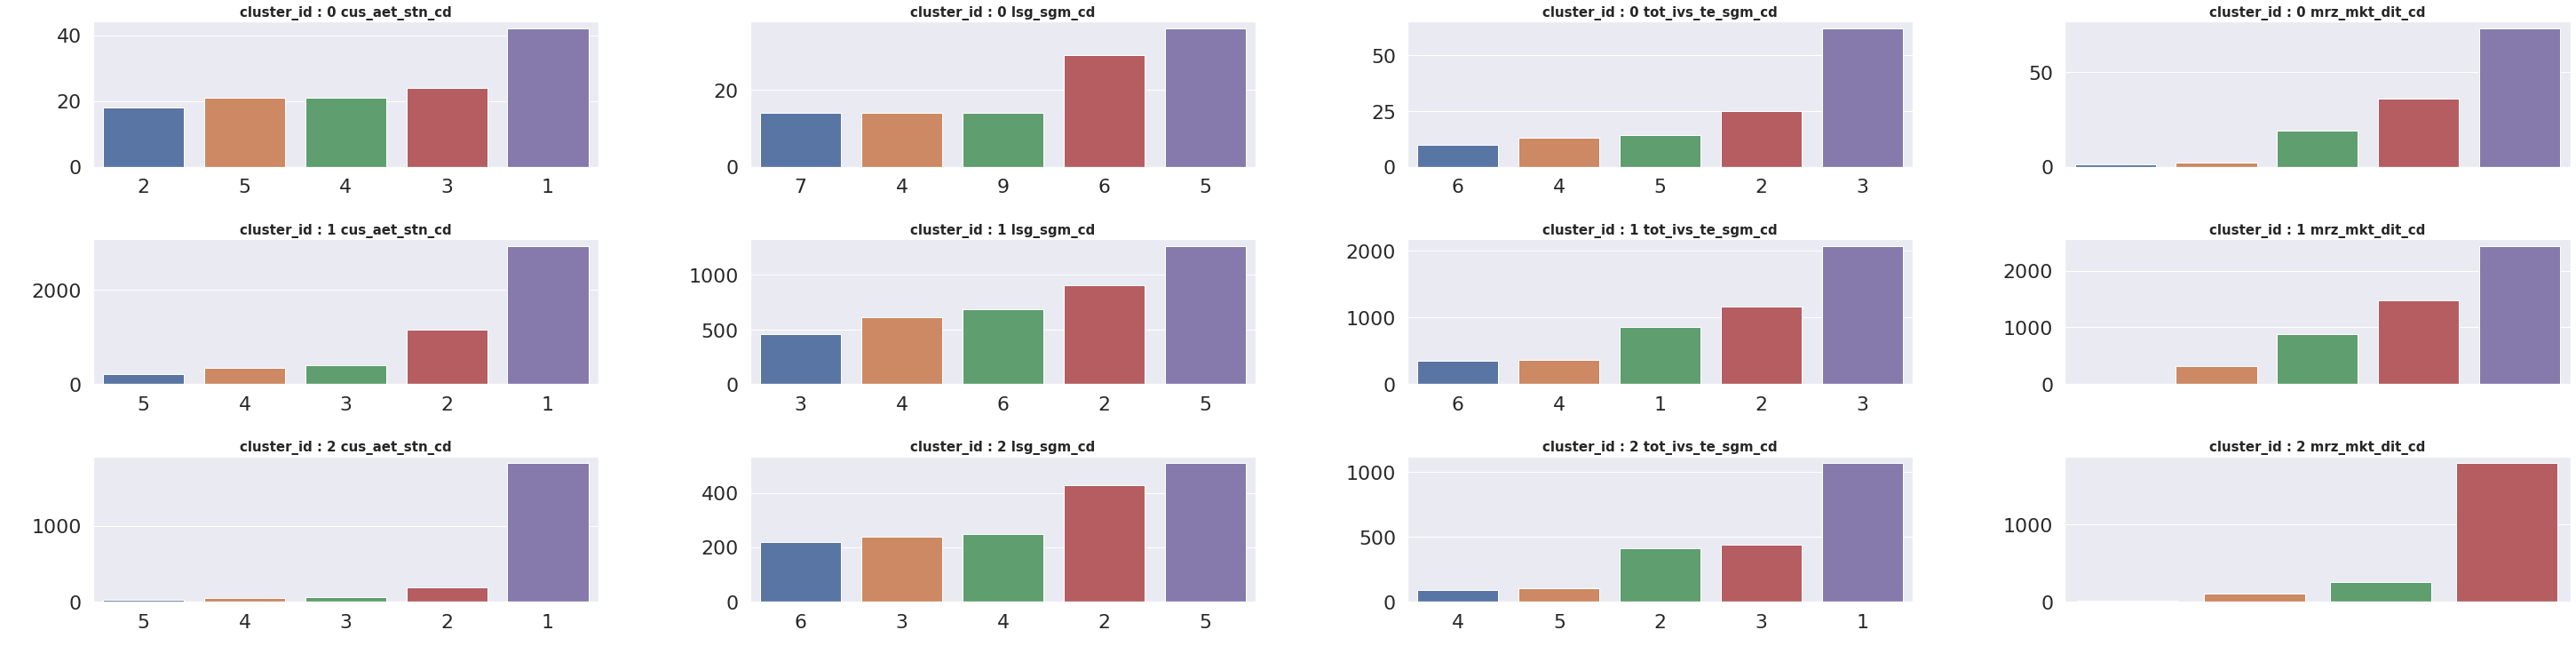

In [159]:
name_list = ['cus_aet_stn_cd', 'lsg_sgm_cd', 'tot_ivs_te_sgm_cd', 'mrz_mkt_dit_cd']
group_plot(only_ko_jan, 3, name_list)

- 202201 기준, 국내주식만하는 only_ko 집단은 3개의 군집의 특징

&nbsp;

- 0번 군집
  - 고객자산구간이 비교적 다양하게 구성
  - 가족성숙기_직장인, 가족성숙기_주부가 주로 분포함
  - 총투자기간이 주로 1년에서 3년 미만

- 1번 군집
  - 고객자산구간이 '0원이상 1천만원미만'인 계좌가 많은 편
  - 가족성숙기_직장인, 사회초년생이 주로 분포함
  - 총투자기간이 주로 1년에서 3년 미만

- 2번 군집
  - 고객자산구간이 '0원이상 1천만원미만'인 계좌 수가 압도적임, 대부분 주식 거래를 거의하지 않는 것으로 해석할 수 있음
  - 가족성숙기_직장인, 사회초년생이 주로 분포함
  - 총투자기간이 6개월미만으로 주식 경험이 굉장히 적은 고객이 대다수



&nbsp;

### 해외 only_oss 그룹, 202201 기준

In [160]:
only_oss_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534 entries, 0 to 3417
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_no             534 non-null    object 
 1   bse_ym             534 non-null    string 
 2   orr_tot_cnt        534 non-null    float64
 3   iem_cnt            534 non-null    float64
 4   dist_index         534 non-null    float64
 5   cus_aet_stn_cd     534 non-null    object 
 6   lsg_sgm_cd         534 non-null    object 
 7   tot_ivs_te_sgm_cd  534 non-null    object 
 8   mrz_mkt_dit_cd     534 non-null    object 
 9   cluster_id         534 non-null    uint16 
dtypes: float64(3), object(5), string(1), uint16(1)
memory usage: 58.9+ KB


- 수치형 변수 군집별 분포 시각화
  - orr_tot_cnt
  - iem_cnt
  - dist_index

<Figure size 576x396 with 0 Axes>

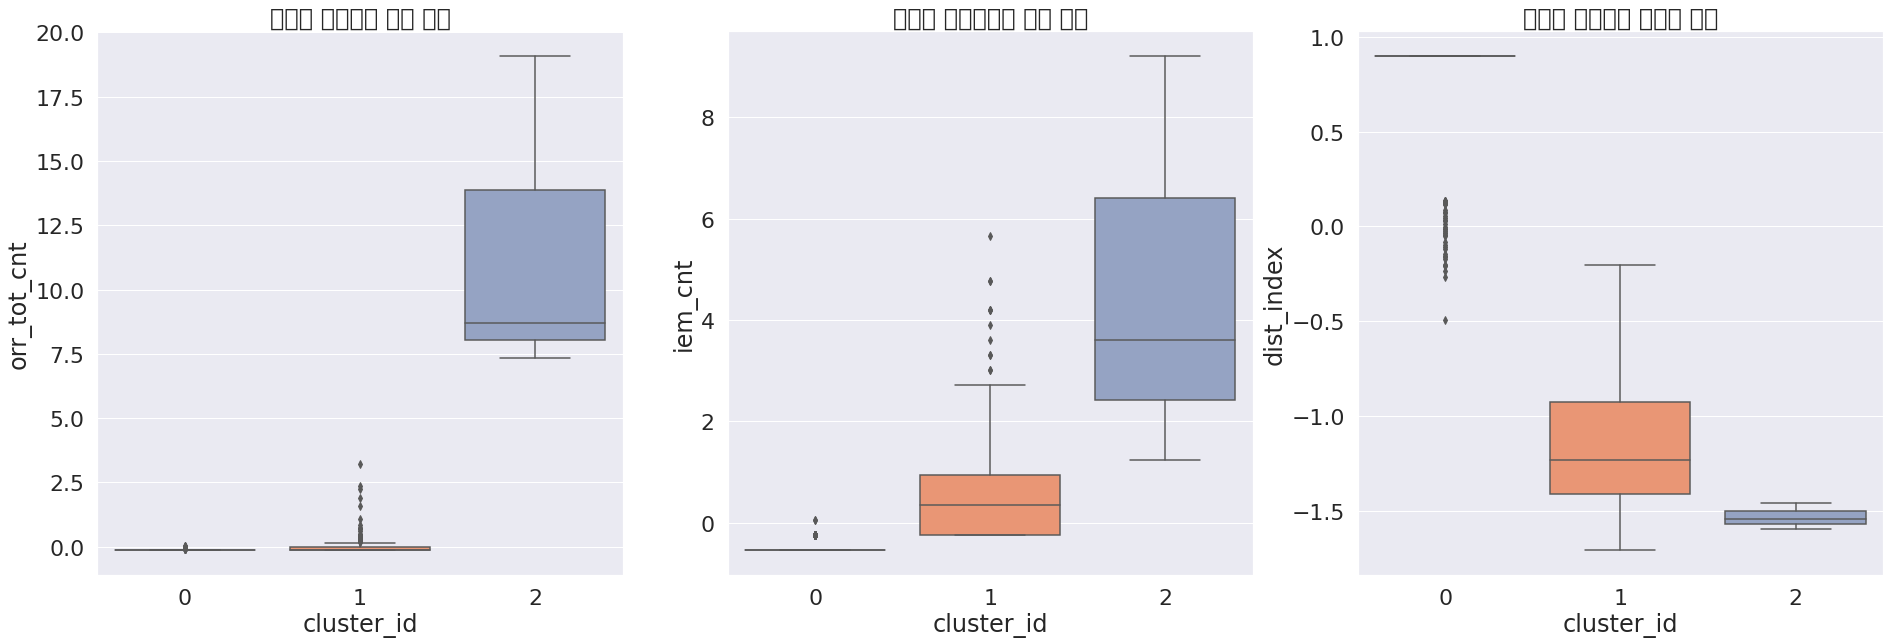

In [161]:
# 글꼴 깨짐 방지
plt.rc('font', family='NanumBarunGothic') 

plt.subplots_adjust(wspace=0.2, hspace = 0.3)

fig = plt.figure(figsize=(32,10))

plt1 = fig.add_subplot(1,3,1)
plt2 = fig.add_subplot(1,3,2)
plt3 = fig.add_subplot(1,3,3)

p1 = sns.boxplot( data = only_oss_jan, x = 'cluster_id', y = 'orr_tot_cnt', ax = plt1, palette = 'Set2')
p2 = sns.boxplot( data = only_oss_jan, x = 'cluster_id', y = 'iem_cnt', ax = plt2, palette = 'Set2')
p3 = sns.boxplot( data = only_oss_jan, x = 'cluster_id', y = 'dist_index', ax = plt3, palette = 'Set2')

p1.set_title('군집별 거래횟수 합계 분포')
p2.set_title('군집별 보유종목수 합계 분포')
p3.set_title('군집별 분산투자 지수값 분포')

sns.set(font_scale=2)

- 202201 기준, 해외주식만 하는 only_oss 집단은 3개의 군집으로 분류

&nbsp;

- 0번 군집
  - 평균 거래횟수와 보유종목 수가 매우 적은 편
  - 분산투자 지수값의 중앙값이 매우 높음
  - 주식 거래를 잘 이용하지 않으며 분산투자하는 경향

- 1번 군집
  - 평균 거래횟수와 보유종목 수가 비교적 적은 편
  - 분산투자 지수값의 중앙값이 비교적 높지는 않음
  - 주식 거래를 활발하게 이용하지 않으며, 상대적으로 집중투자하는 경향

- 2번 군집
  - 평균 거래횟수와 보유종목 수가 매우 많은 편
  - 분산투자 지수값의 중앙값이 낮음
  - 주식 거래를 거의 이용하지 않으며 한 종목에 집중적으로 투자하려는 경향



&nbsp;


> 각 군집의 특성을 파악했을 때 `주식에 관심이 많으며 위험을 감수하며 집중투자를 하는 고객군`, `주식을 활발히 하지는 않지만 주식을 통해 안정적인 수익을 창출하고자 하는 고객군`,`주식에 관심이 없고 안정성을 추구하려는 고객군`으로 분류할 수 있습니다.

- 범주형 변수 군집별 시각화
  - cus_aet_stn_cd     
  - lsg_sgm_cd         
  - tot_ivs_te_sgm_cd
  - mrz_mkt_dit_cd 

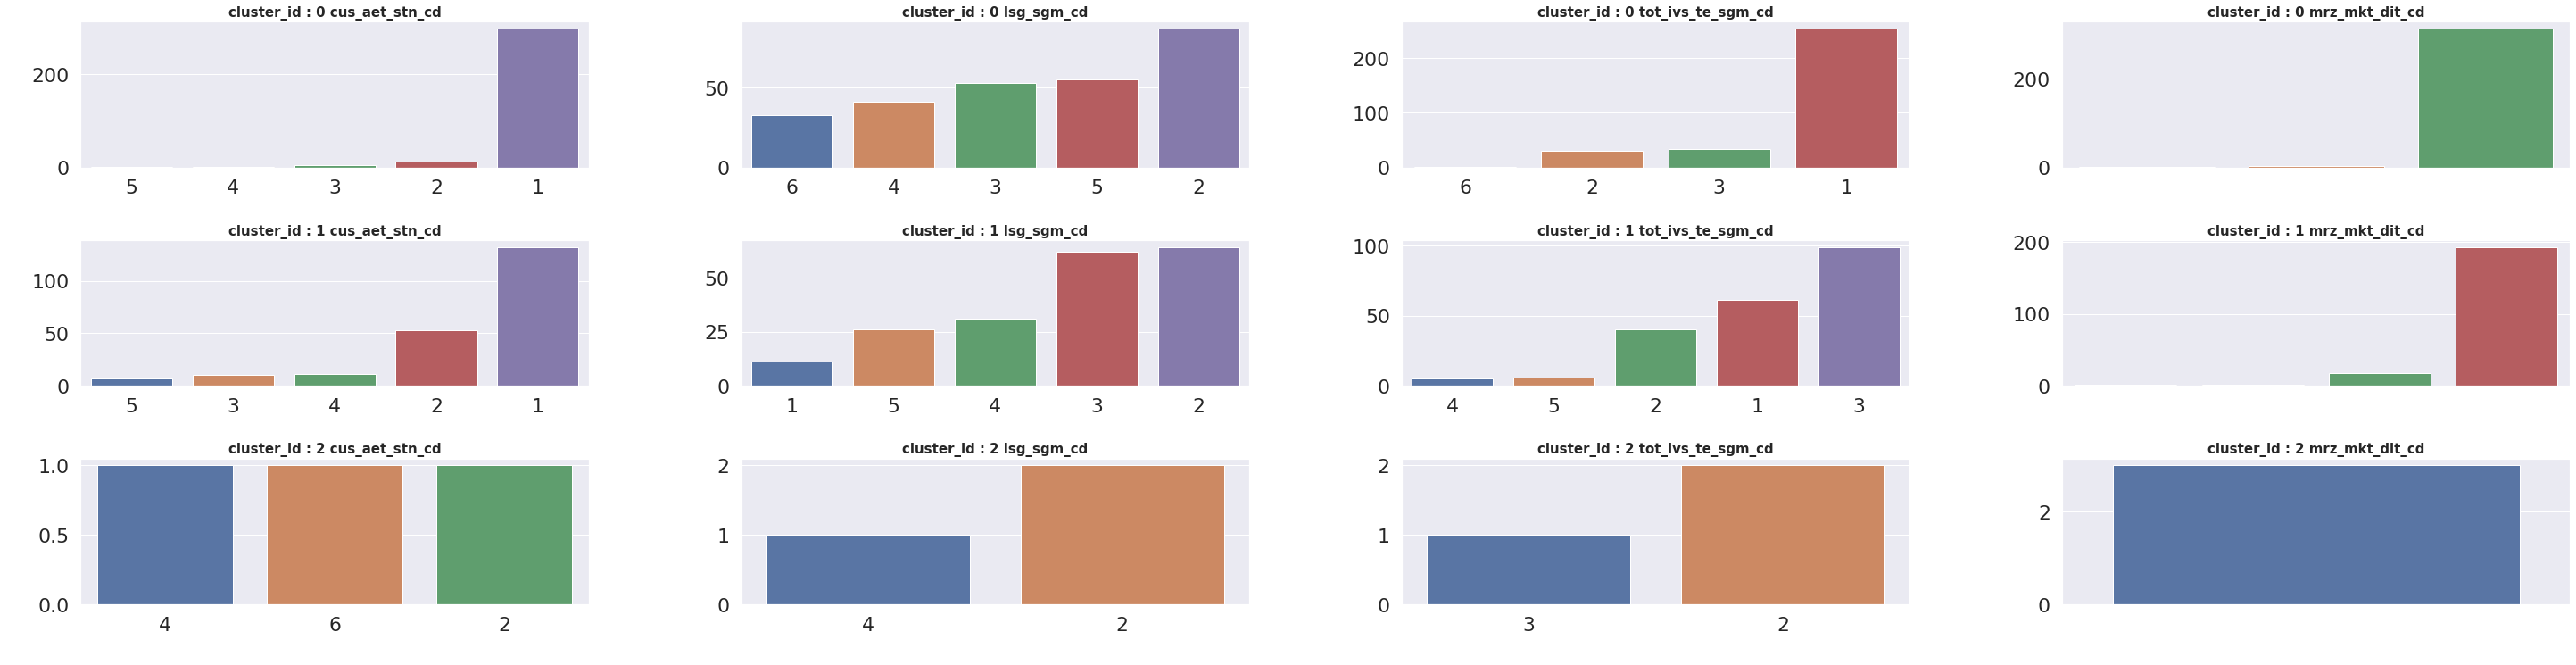

In [162]:
name_list = ['cus_aet_stn_cd', 'lsg_sgm_cd', 'tot_ivs_te_sgm_cd', 'mrz_mkt_dit_cd']
group_plot(only_oss_jan, 3, name_list)

- 202201 기준, 해외주식만 하는 only_oss 집단은 3개의 군집의 특징

&nbsp;

- 0번 군집
  - 고객자산구간이 비교적 다양하게 구성
  - 가족성숙기_직장인, 가족성숙기_주부가 주로 분포함
  - 총투자기간이 주로 6개월미만으로, 매우 최근에 투자를 시작함

- 1번 군집
  - 고객자산구간이 '0원이상 1천만원미만'인 계좌가 많은 편
  - 가족성숙기_직장인, 사회초년생이 주로 분포함
  - 총투자기간이 주로 1년에서 3년 미만

- 2번 군집
  - 고객자산구간이 다양함
  - 사회초년생이 주로 분포함
  - 총투자기간이 모두 3년 미만으로 주식시장의 변동성이 큰 기간에 주식 투자를 시작



&nbsp;

### 모두 both 그룹, 202201 기준

In [163]:
both_jan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 6713
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   act_no             1043 non-null   object 
 1   bse_ym             1043 non-null   string 
 2   orr_tot_cnt        1043 non-null   float64
 3   kr_ratio           1043 non-null   float64
 4   iem_cnt            1043 non-null   float64
 5   dist_index         1043 non-null   float64
 6   cus_aet_stn_cd     1043 non-null   object 
 7   lsg_sgm_cd         1043 non-null   object 
 8   tot_ivs_te_sgm_cd  1043 non-null   object 
 9   mrz_mkt_dit_cd     1043 non-null   object 
 10  cluster_id         1043 non-null   uint16 
dtypes: float64(4), object(5), string(1), uint16(1)
memory usage: 124.0+ KB


- 수치형 변수 군집별 분포 시각화
  - orr_tot_cnt
  - iem_cnt
  - dist_index
  - kr_ratio

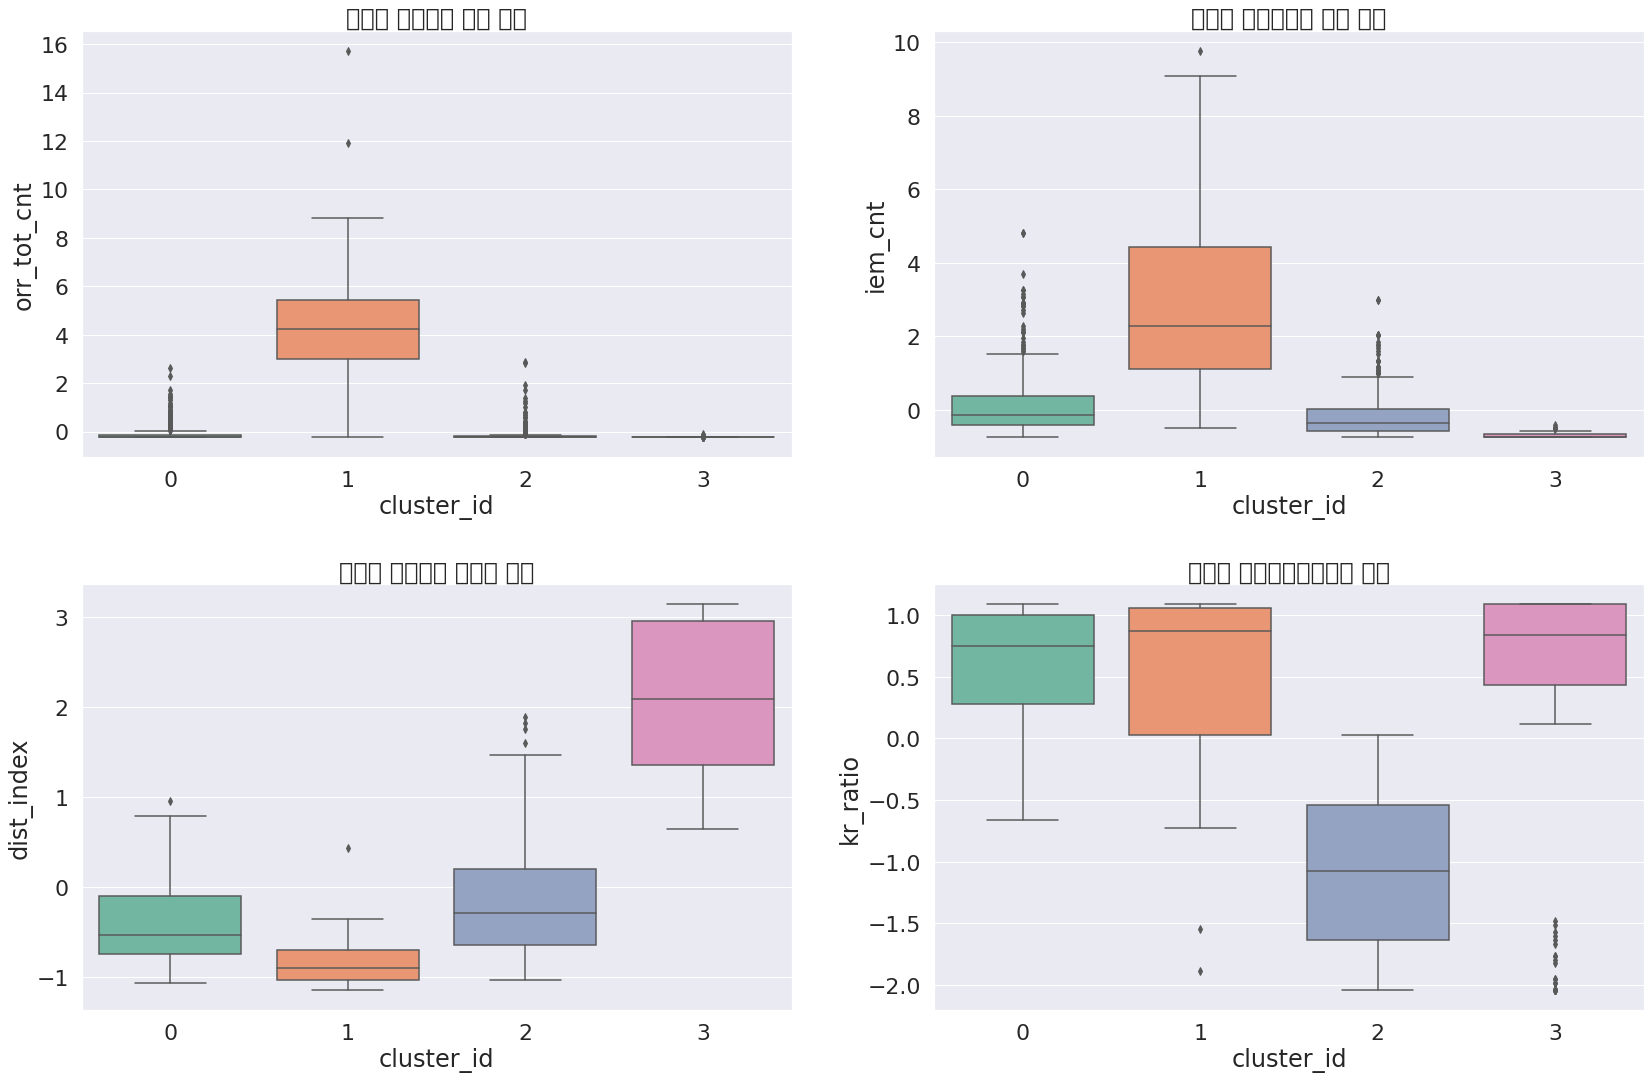

In [164]:
# 글꼴 깨짐 방지
plt.rc('font', family='NanumBarunGothic') 

fig,ax=plt.subplots(nrows=2,ncols=2 , figsize=(28,18))
plt.subplots_adjust(wspace=0.2, hspace = 0.3)

p1 = sns.boxplot( data = both_jan, x = 'cluster_id', y = 'orr_tot_cnt', ax = ax[0, 0], palette = 'Set2')
p2 = sns.boxplot( data = both_jan, x = 'cluster_id', y = 'iem_cnt', ax = ax[0, 1], palette = 'Set2')
p3 = sns.boxplot( data = both_jan, x = 'cluster_id', y = 'dist_index', ax = ax[1, 0], palette = 'Set2')
p4 = sns.boxplot( data = both_jan, x = 'cluster_id', y = 'kr_ratio', ax = ax[1, 1], palette = 'Set2')

p1.set_title('군집별 거래횟수 합계 분포')
p2.set_title('군집별 보유종목수 합계 분포')
p3.set_title('군집별 분산투자 지수값 분포')
p4.set_title('군집별 국내주식투자비중 분포')

sns.set(font_scale=2)

- 202201 기준, 국내주식만하는 only_ko 집단은 3개의 군집으로 분류

&nbsp;

- 0번 군집
  - 평균 거래횟수와 보유종목 수가 적은 편
  - 분산투자 지수값의 중앙값이 낮고 변동성 지수값의 중앙값은 높은 편
  - 주식 거래를 활발히 이용하지 않으며 안정적인 주식에 집중투자하는 편

- 1번 군집
  - 평균 거래횟수와 보유종목 수가 매우 많은 편
  - 분산투자 지수값의 중앙값은 매우 낮고 변동성 지수값의 중앙값은 높음
  - 주식 거래를 활발하게 이용하며 변동성이 적은 종목에 집중투자하는 경향

- 2번 군집
  - 평균 거래횟수와 보유종목 수가 적은 편
  - 분산투자 지수값의 중앙값과 변동성 지수값의 중앙값은 낮은 편
  - 주식 거래를 잘 하지 않고, 위험이 적은 종목에 집중투자하는 경향

- 3번 군집
  - 평균 거래횟수와 보유종목 수가 거의 없는 편
  - 분산투자 지수값의 중앙값과 변동성 지수값의 중앙값이 매우 높음
  - 주식 거래를 거의 이용하지 않으며 변동성이 높은 주식에 분산투자 하는 경향



&nbsp;


> 각 군집의 특성을 파악했을 때 `주식에 대한 관심이 적으며 안정적인 주식에 집중적으로 투자하는 고객군`, `주식에 열정적이며 안전한 종목에 투자하여 수익창출 기대하는 고객군`,`주식을 활발하게 하지는 않지만 위험이 적은 종목에 집중투자하는 고객군`, `주식을 거의 안하지만 높은 변동성을 보이는 종목에 분산투자하는 고객군`으로 분류할 수 있습니다.

- 범주형 변수 군집별 시각화
  - cus_aet_stn_cd     
  - lsg_sgm_cd         
  - tot_ivs_te_sgm_cd
  - mrz_mkt_dit_cd 

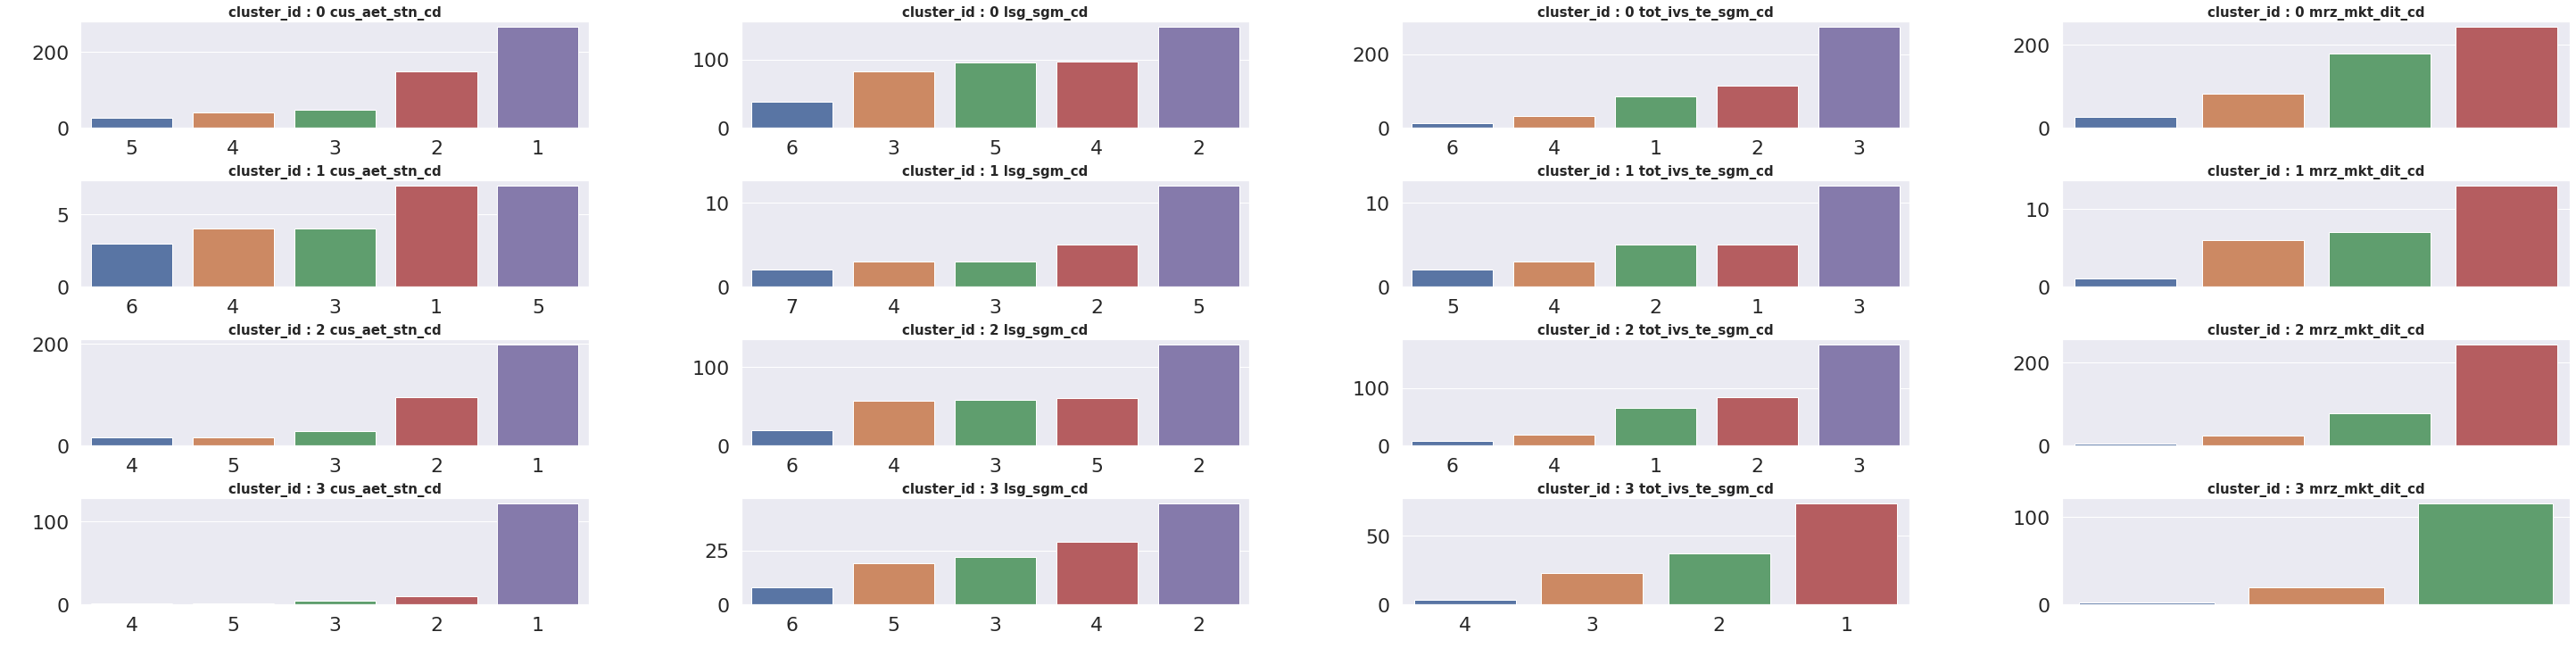

In [165]:
name_list = ['cus_aet_stn_cd', 'lsg_sgm_cd', 'tot_ivs_te_sgm_cd', 'mrz_mkt_dit_cd']
group_plot(both_jan, 4, name_list)

- 202201 기준, 국내/해외주식 모두 하는 both 집단 내 4개의 군집의 특징

&nbsp;

- 0번 군집
  - 고객자산구간이 '0원이상 1천만원 미만'인 계좌가 많은 편
  - 사회초년생, 가족형성기_여자가 주로 분포함
  - 총투자기간이 주로 3년 미만으로 주식시장의 변동성이 큰 기간에 주식 투자를 시작

- 1번 군집
  - 고객자산구간이 '1억원이상 3억원미만'인 계좌가 많은 편, 주식투자를 적극적으로 하는 편으로 추정
  - 가족성숙기_직장인, 사회초년생이 주로 분포함
  - 총투자기간이 주로 3년 미만으로 주식시장의 변동성이 큰 기간에 주식 투자를 시작

- 2번 군집
  - 고객자산구간이 '0원이상 1천만원 미만'인 계좌가 많은 편
  - 사회초년생, 가족성숙기_직장인이 주로 분포함
  - 총투자기간이 주로 3년 미만으로 주식시장의 변동성이 큰 기간에 주식 투자를 시작

- 3번 군집
  - 고객자산구간이 '0원이상 1천만원 미만'인 계좌가 많은 편
  - 사회초년생, 가족형성기_여자가 주로 분포함
  - 총투자기간이 주로 6개월미만으로, 매우 최근에 투자를 시작함



&nbsp;

## 결과 생성

In [166]:
# csv 파일로 저장
only_ko_jan.to_csv('only_ko(202201).csv', index = False, encoding = 'utf-8-sig')
only_oss_jan.to_csv('only_oss(202201).csv', index = False, encoding = 'utf-8-sig')
both_jan.to_csv('both(202201).csv', index = False, encoding = 'utf-8-sig')

### 고객정보기준년월 : 202201 이외에 나머지 년월에 대해서도 분류 모델링 시행

#### only_ko 집단

In [167]:
## only_ko 집단/ 고객정보기준년월 : 202202
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(kom2[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
only_ko_feb['cluster_id'] = kprototype.labels_ 

In [168]:
## only_ko 집단/ 고객정보기준년월 : 202203
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(kom3[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
only_ko_mar['cluster_id'] = kprototype.labels_ 

In [169]:
## only_ko 집단/ 고객정보기준년월 : 202204
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(kom4[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
only_ko_apr['cluster_id'] = kprototype.labels_ 

In [170]:
## only_ko 집단/ 고객정보기준년월 : 202205
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(kom5[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
only_ko_may['cluster_id'] = kprototype.labels_ 

In [171]:
## only_ko 집단/ 고객정보기준년월 : 202206
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(kom6[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
only_ko_jun['cluster_id'] = kprototype.labels_ 

#### only_oss 집단

In [172]:
## 고객정보기준년월 : 202202
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(osm2[:,2:], categorical = [3,4,5,6])

# 클러스터링 결과를 데이터프레임에 추가
only_oss_feb['cluster_id'] = kprototype.labels_ 

In [173]:
## 고객정보기준년월 : 202203
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(osm3[:,2:], categorical = [3,4,5,6])

# 클러스터링 결과를 데이터프레임에 추가
only_oss_mar['cluster_id'] = kprototype.labels_ 

In [174]:
## 고객정보기준년월 : 202204
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(osm4[:,2:], categorical = [3,4,5,6])

# 클러스터링 결과를 데이터프레임에 추가
only_oss_apr['cluster_id'] = kprototype.labels_ 

In [175]:
## 고객정보기준년월 : 202205
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(osm5[:,2:], categorical = [3,4,5,6])

# 클러스터링 결과를 데이터프레임에 추가
only_oss_may['cluster_id'] = kprototype.labels_ 

In [176]:
## 고객정보기준년월 : 202206
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(osm6[:,2:], categorical = [3,4,5,6])

# 클러스터링 결과를 데이터프레임에 추가
only_oss_jun['cluster_id'] = kprototype.labels_  

#### both 집단

In [177]:
## 고객정보기준년월 : 202202
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(bm2[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
both_feb['cluster_id'] = kprototype.labels_ 

In [178]:
## 고객정보기준년월 : 202203
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(bm3[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
both_mar['cluster_id'] = kprototype.labels_ 

In [179]:
## 고객정보기준년월 : 202204
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(bm4[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
both_apr['cluster_id'] = kprototype.labels_ 

In [180]:
## 고객정보기준년월 : 202205
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(bm5[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
both_may['cluster_id'] = kprototype.labels_ 

In [181]:
## 고객정보기준년월 : 202206
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 0)
kprototype.fit_predict(bm6[:,2:], categorical = [4,5,6,7])

# 클러스터링 결과를 데이터프레임에 추가
both_jun['cluster_id'] = kprototype.labels_ 

### 나머지 결과물 생성


In [182]:
# csv 파일로 저장
only_ko_feb.to_csv('only_ko(202202).csv', index = False, encoding = 'utf-8-sig')
only_ko_mar.to_csv('only_ko(202203).csv', index = False, encoding = 'utf-8-sig')
only_ko_apr.to_csv('only_ko(202204).csv', index = False, encoding = 'utf-8-sig')
only_ko_may.to_csv('only_ko(202205).csv', index = False, encoding = 'utf-8-sig')
only_ko_jun.to_csv('only_ko(202206).csv', index = False, encoding = 'utf-8-sig')

only_oss_feb.to_csv('only_oss(202202).csv', index = False, encoding = 'utf-8-sig')
only_oss_mar.to_csv('only_oss(202203).csv', index = False, encoding = 'utf-8-sig')
only_oss_apr.to_csv('only_oss(202204).csv', index = False, encoding = 'utf-8-sig')
only_oss_may.to_csv('only_oss(202205).csv', index = False, encoding = 'utf-8-sig')
only_oss_jun.to_csv('only_oss(202206).csv', index = False, encoding = 'utf-8-sig')

both_feb.to_csv('both(202202).csv', index = False, encoding = 'utf-8-sig')
both_mar.to_csv('both(202203).csv', index = False, encoding = 'utf-8-sig')
both_apr.to_csv('both(202204).csv', index = False, encoding = 'utf-8-sig')
both_may.to_csv('both(202205).csv', index = False, encoding = 'utf-8-sig')
both_jun.to_csv('both(202206).csv', index = False, encoding = 'utf-8-sig')